# Scenario Analysis - "Grid modelling to assess electrofuels supply potential - The impact of electrofuels on the US electricity grid"

This notebook reports the results of preliminary runs for the scenarios defined in the table [here](https://docs.google.com/document/d/1ssc5ilxEhEYYjFDCo5cIAgP7zSRcO4uVUXjxbyfR88Q/edit?tab=t.0). In this notebook, a single scenario is analyzed. Another notebook is available for multi-scenario comparison.

**Scenarios Analyzed:**
- *Scenario 1: [Brief Description]*
- *Scenario 2: [Brief Description]*
- *Scenario 10: [Brief Description]*

---

## 1. Setup and Data Loading

*This section handles the initial setup, including importing necessary libraries and loading the solved PyPSA network data for each scenario.*

### 1.1. Import Libraries

In [1]:
!pip install plotly -qq

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pycountry

import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from pathlib import Path

import cartopy.crs as ccrs # For plotting maps
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.patches import Wedge
import matplotlib.path as mpath
import matplotlib.transforms as mtransforms
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import plotly.express as px
import plotly.graph_objects as go

from shapely.geometry import LineString
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import yaml

import warnings
warnings.filterwarnings("ignore")

from _helpers import (
    attach_grid_region_to_buses, attach_state_to_buses, compute_demand,
    compute_data_center_load, compute_carrier_costs, fill_missing_color,
    fill_missing_nice_names, update_ac_dc_bus_coordinates, assign_location,
    create_hydrogen_capacity_map, print_hydrogen_capacity_summary, create_ft_capacity_by_grid_region_map,
    create_ft_capacity_map, compute_h2_capacities, plot_h2_capacities_bar, calculate_dispatch, 
    plot_electricity_dispatch, compute_and_plot_load, calculate_lcoe_summary_and_map,
    plot_lcoe_map_by_grid_region, plot_h2_capacities_map
    )

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



### 1.2. Load Solved Network(s)

Scenario 1 is used as default for the analysis. Please change the number in `scenario_dir` to analyze a different scenario. The base year results are common for all the scenarios.

In [3]:
# -----------------------------
# Project folder path
# -----------------------------
project_root = Path().resolve()

# -----------------------------
# Base year network path
# -----------------------------
base_year_file = project_root / "results" / "base_year" / "elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc"

networks = {
    "Base_2023": pypsa.Network(base_year_file)
}

# -----------------------------
# Scenario folder path (single scenario)
# -----------------------------
scenario_dir = project_root / "results" / "scenarios" / "scenario_01" #change the number to choose the scenario of your interest

## Folder structure
#  project_root/
#  └── notebooks/
#       ├── scenario_analysis.ipynb
#       └── results/
#            ├── base_year/
#            │   ├── elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc
#            └── scenarios/
#                 ├── scenario_01/
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc
#                 │   └── elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc
#                 ├── scenario_02/
#                 ├── ...
#                 ├── scenario_10/

years = [2030, 2035, 2040]

# -----------------------------
# Upload available networks per year
# -----------------------------
for year in years:
    file_name = f"elec_s_100_ec_lcopt_3H_3H_{year}_0.071_AB_10export.nc"
    file_path = scenario_dir / file_name

    if file_path.exists():
        scenario_name = scenario_dir.name  # e.g., "scenario_01"
        key = f"{scenario_name}_{year}"
        networks[key] = pypsa.Network(file_path)
        print(f"Loaded: {key}")
    else:
        print(f"Missing: {file_path.relative_to(project_root)}")

network_names = list(networks.keys())
print("\n Uploaded networks:")
print(list(networks.keys()))

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_01_2030


INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_01_2035


INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loaded: scenario_01_2040

 Uploaded networks:
['Base_2023', 'scenario_01_2030', 'scenario_01_2035', 'scenario_01_2040']


In [4]:
grid_region_shapes_path = project_root / "needs_grid_regions_aggregated.geojson"
state_shapes_path = project_root / "gadm41_USA_1.json"

regions_onshore = gpd.read_file(grid_region_shapes_path)

In [5]:
with open('plotting.yaml', 'r') as file:
    plotting = yaml.safe_load(file)

tech_colors = plotting['tech_colors']
nice_names = plotting['nice_names']
rename_techs = plotting['rename_tech']
rename_tech_colors = plotting['renamed_tech_colors']

In [6]:
for network in networks.keys():
    attach_grid_region_to_buses(networks[network], grid_region_shapes_path)
    attach_state_to_buses(networks[network], state_shapes_path)

---

## 2. Input Data Analysis & Validation

*Before diving into results, we validate and visualize the key input data that drives the model. This primarily focuses on electricity demand.*

### 2.1. Demand Projections & Overview
*A summary of the overall demand assumptions for the model years.*

In [7]:
# Code to extract and display demand assumptions
# e.g., total annual TWh demand per country
pass

### 2.2. Country-wise Total Electricity Demand (Time Series)
*This plot shows the electricity demand profile over the year for each country, which is a primary driver for the system's operation.*

In [8]:
networks.keys()

dict_keys(['Base_2023', 'scenario_01_2030', 'scenario_01_2035', 'scenario_01_2040'])

In [9]:
target_processes = [
    "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
    "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
    "dry clinker", "cement finishing", "dry clinker CC"
]
static_load_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
dynamic_load_carriers = ["AC", "services electricity", "land transport EV"]

demand = pd.DataFrame(columns=networks.keys(), index=dynamic_load_carriers+static_load_carriers+["total demand"])
demand_profile = pd.DataFrame(columns=networks.keys(), index=networks["Base_2023"].snapshots)
ac_load, services_load, ev_load = 0, 0, 0

for name, n in networks.items():

    # calculate static loads and its profile
    nhours = n.snapshot_weightings.objective.sum()
    static_totals = (
        n.loads.groupby("carrier")
            .sum().p_set
            .reindex(static_load_carriers)
            .fillna(0)
    )
    static_load_twh = static_totals.sum() * nhours / 1e6

    process_links = n.links[n.links.carrier.isin(target_processes)]
    ac_input_links = process_links[process_links.bus0.map(n.buses.carrier) == "AC"].index

    ind_ac_profile = n.links_t.p0[ac_input_links].sum(axis=1)
    ind_ac_twh = (ind_ac_profile * n.snapshot_weightings.objective).sum() / 1e6

    ac_loads = n.loads[n.loads.carrier == "AC"]
    industrial_ac_buses = n.links.loc[ac_input_links, "bus0"].unique()
    ac_non_ind_idx = ac_loads[~ac_loads.bus.isin(industrial_ac_buses)].index
    ac_profile = n.loads_t.p_set[ac_non_ind_idx.intersection(n.loads_t.p_set.columns)].sum(axis=1)
    ac_twh = (ac_profile * n.snapshot_weightings.objective).sum() / 1e6 - ind_ac_twh

    # calculate dynamic loads and profiles
    # ac_loads = n.loads.query("carrier in 'AC'").index
    # ac_profile = n.loads_t.p_set[ac_loads].sum(axis=1)
    # ac_load = ac_profile.multiply(n.snapshot_weightings.objective, axis=0).sum() / 1e6

    # 3. Services & EV
    serv_idx = [i for i in n.loads[n.loads.carrier == "services electricity"].index
                if i in n.loads_t.p_set.columns]
    ev_idx   = [i for i in n.loads[n.loads.carrier == "land transport EV"].index
                if i in n.loads_t.p_set.columns]

    serv_profile = n.loads_t.p_set[serv_idx].sum(axis=1) if serv_idx else 0
    ev_profile   = n.loads_t.p_set[ev_idx].sum(axis=1)   if ev_idx else 0

    serv_twh = (serv_profile * n.snapshot_weightings.objective).sum() / 1e6
    ev_twh   = (ev_profile   * n.snapshot_weightings.objective).sum() / 1e6

    # 4. Industry electricity total = static + industrial AC
    industry_static_twh = static_totals.get("industry electricity", 0) * nhours / 1e6
    industry_elec_twh = industry_static_twh + ind_ac_twh

    dynamic_profile = ac_profile + serv_profile + ev_profile
    demand_profile.loc[:, name] = dynamic_profile + static_totals.sum()

    demand.loc["rail transport electricity", name] = static_totals.get("rail transport electricity", 0) * nhours / 1e6
    demand.loc["agriculture electricity",      name] = static_totals.get("agriculture electricity",  0) * nhours / 1e6
    demand.loc["industry electricity",         name] = industry_elec_twh
    demand.loc["AC",                           name] = ac_twh
    demand.loc["services electricity",         name] = serv_twh
    demand.loc["land transport EV",            name] = ev_twh
    demand.loc["total demand",                 name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh
    )


In [10]:
demand

Base_2023 scenario_01_2030 scenario_01_2035  \
AC                          1399.790281      1490.519908      1558.831601   
services electricity        1338.936409      1386.508012      1421.519077   
land transport EV             69.576977       318.254464        550.52874   
rail transport electricity       5.5476           5.5476           5.5476   
agriculture electricity         57.3213          57.3213          57.3213   
industry electricity         804.420936       886.717069       932.849589   
total demand                3675.593503      4144.868353      4526.597907   

                           scenario_01_2040  
AC                              1630.208261  
services electricity            1457.414215  
land transport EV                733.479015  
rail transport electricity           5.5476  
agriculture electricity             57.3213  
industry electricity             981.953359  
total demand                     4865.92375

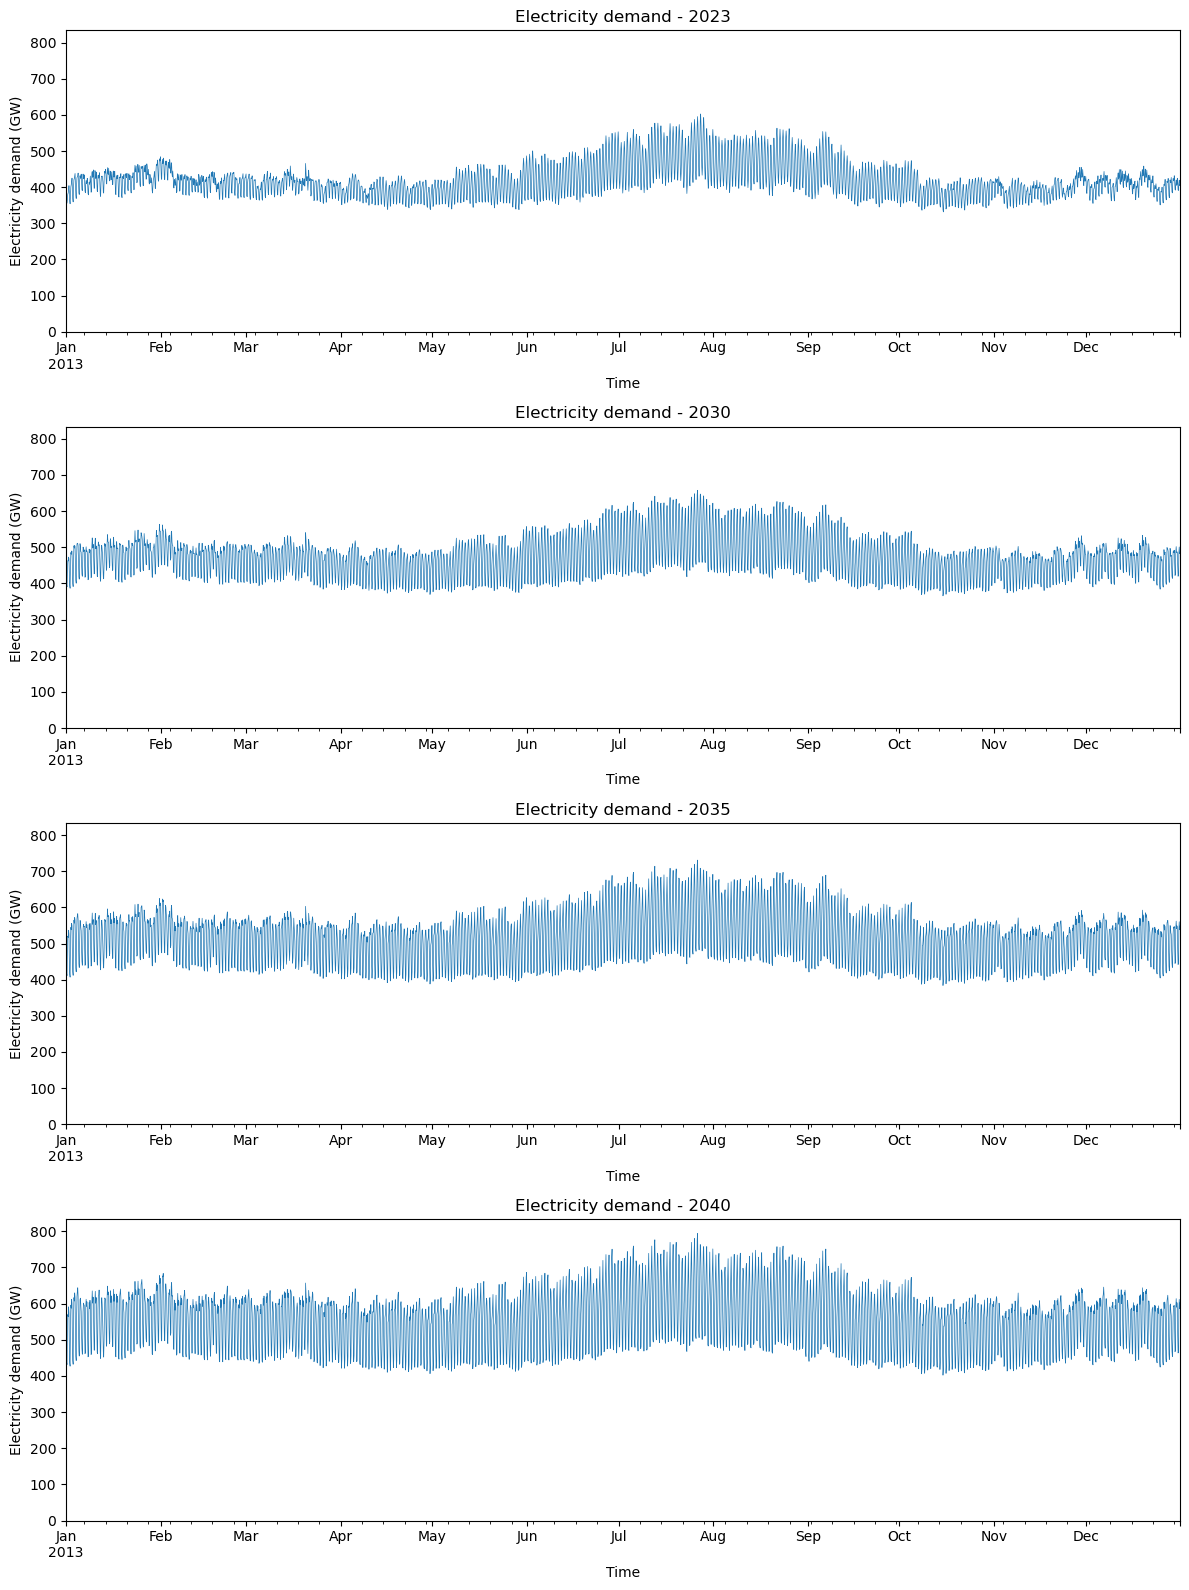

In [11]:
years = set()
for col in demand_profile.columns:
    match = re.search(r"\d{4}", col)
    if match:
        years.add(int(match.group()))

years = sorted(years)

fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(12, 4 * len(years)))

y_max = (demand_profile / 1e3).max().max() * 1.05

for ax, year in zip(axes, years):
    cols = [col for col in demand_profile.columns if str(year) in col]
    if cols:
        (demand_profile[cols] / 1e3).plot(ax=ax, linewidth=0.5, legend = False)
        ax.set_title(f"Electricity demand - {year}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Electricity demand (GW)")
        ax.set_ylim(0, y_max)
    else:
        ax.set_visible(False)

plt.tight_layout()

### 2.3. State-wise Total Electricity Demand (Validation Year)
*A bar plot showing the total annual electricity demand for each state or region for the validation year. This helps confirm the spatial distribution of demand.*

In [12]:
base_demand_grid_region, base_demand_state = compute_demand(networks["Base_2023"])

In [13]:
base_demand_grid_region.T

region                      Alaska  California  Delta  Florida  Hawaii  \
carrier                                                                  
AC                            1.26      102.02  57.89    80.28    3.56   
agriculture electricity       0.05        5.29   1.59     2.89    0.16   
industry electricity          0.94       66.54  38.79    23.17    2.46   
land transport EV             0.06        6.34   1.86     3.32    0.19   
rail transport electricity    0.00        0.52   0.16     0.28    0.02   
services electricity          1.14       92.81  52.68    73.04    3.24   

region                      Mid-Atlantic  Midwest  Mountain  New England  \
carrier                                                                    
AC                                298.50   178.02     39.76        32.26   
agriculture electricity             9.23     7.64      2.94         2.00   
industry electricity              135.94    96.52     31.38        29.72   
land transport EV                  11.27     9.53      3.65         2.49   
rail transport electricity          0.89     0.75      0.30         0.20   
services electricity              271.56   161.99     36.18        29.36   

region                      New York  Northwest  Plains  Southeast  Southwest  \
carrier                                                                         
AC                             73.75      76.83  110.49     206.30      58.97   
agriculture electricity         4.63       2.50    4.91       7.05       2.70   
industry electricity           75.22      26.61   57.86      65.37      21.24   
land transport EV               5.75       3.10    6.07       8.33       3.24   
rail transport electricity      0.45       0.24    0.48       0.70       0.27   
services electricity           67.11      69.89  100.52     187.68      53.65   

region                       Texas  
carrier                             
AC                          151.80  
agriculture electricity       3.78  
industry electricity         60.67  
land transport EV             4.40  
rail transport electricity    0.37  
services electricity        138.11

In [14]:
base_demand_state.T

region                        AK     AL    AR     AZ      CA     CO     DE  \
carrier                                                                      
AC                          1.26  25.09  9.56  30.75  107.06  17.52  22.48   
agriculture electricity     0.05   0.74  0.22   1.36    6.81   0.78   1.41   
industry electricity        0.94   9.79  2.38   9.42   81.83   8.16  28.04   
land transport EV           0.06   0.86  0.26   1.62    8.21   0.99   1.71   
rail transport electricity  0.00   0.08  0.02   0.14    0.67   0.08   0.14   
services electricity        1.14  22.82  8.70  27.98   97.40  15.94  20.45   

region                         FL     GA    HI  ...     PA     SC    SD  \
carrier                                         ...                       
AC                          80.28  57.46  3.56  ...  39.34  28.83  3.07   
agriculture electricity      2.89   2.28  0.16  ...   2.08   1.10  0.19   
industry electricity        23.17  18.17  2.46  ...  27.13   9.24  2.18   
land transport EV            3.32   2.66  0.19  ...   2.56   1.31  0.23   
rail transport electricity   0.28   0.22  0.02  ...   0.20   0.11  0.02   
services electricity        73.04  52.27  3.24  ...  35.79  26.23  2.79   

region                         TN      TX     UT     VA     WA     WI    WY  
carrier                                                                      
AC                          46.92  173.36  11.19  93.34  32.30  23.72  3.85  
agriculture electricity      1.60    4.57   0.38   1.28   1.01   1.35  0.06  
industry electricity        16.95   68.87   3.44  15.18  13.92  15.17  1.25  
land transport EV            1.91    5.34   0.47   1.54   1.25   1.72  0.07  
rail transport electricity   0.16    0.45   0.04   0.12   0.10   0.13  0.01  
services electricity        42.69  157.72  10.18  84.92  29.38  21.59  3.51  

[6 rows x 45 columns]

In [15]:
fig1 = px.bar(base_demand_grid_region, barmode='stack', text_auto='.1f')
fig1.update_layout(width=1000, yaxis_title='Demand (TWh)', xaxis_title='Grid region', title='Electricity Demand by Carrier and Grid region (2023)')
fig1.show()

fig1 = px.bar(base_demand_state, barmode='stack', text_auto='.1f')
fig1.update_layout(width=1000, yaxis_title='Demand (TWh)', xaxis_title='State', title='Electricity Demand by Carrier and State (2023)')
fig1.show()

### 2.4. Data Center Loads/Demands
*Isolating and visualizing the specific demand profile of data centers to understand their impact on the system.*

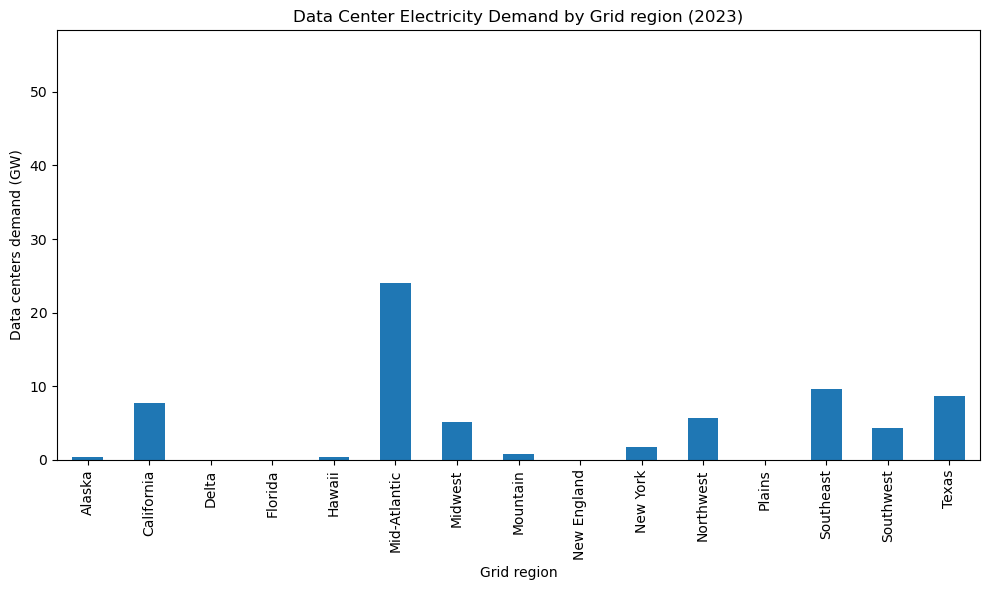

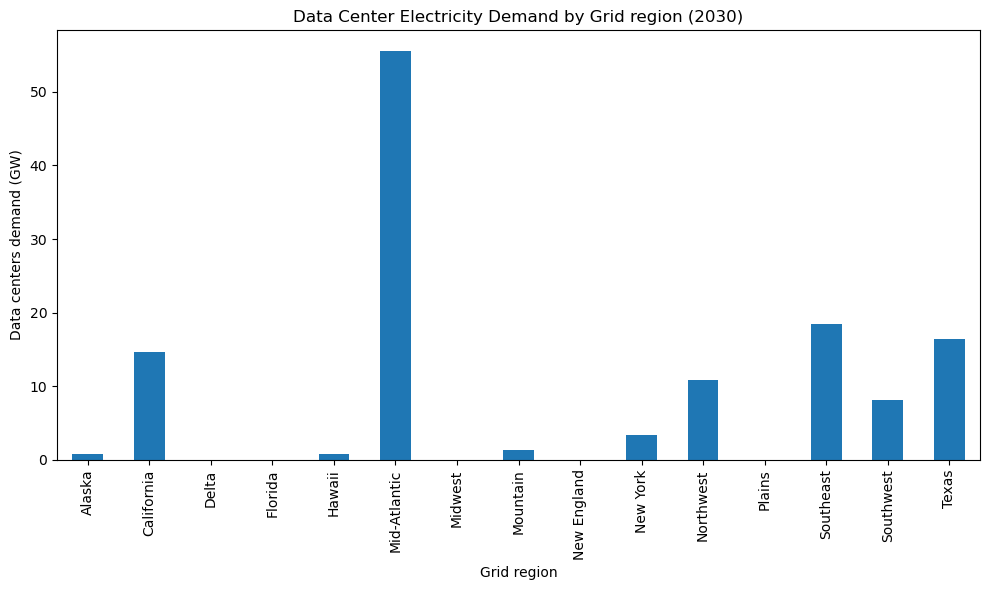

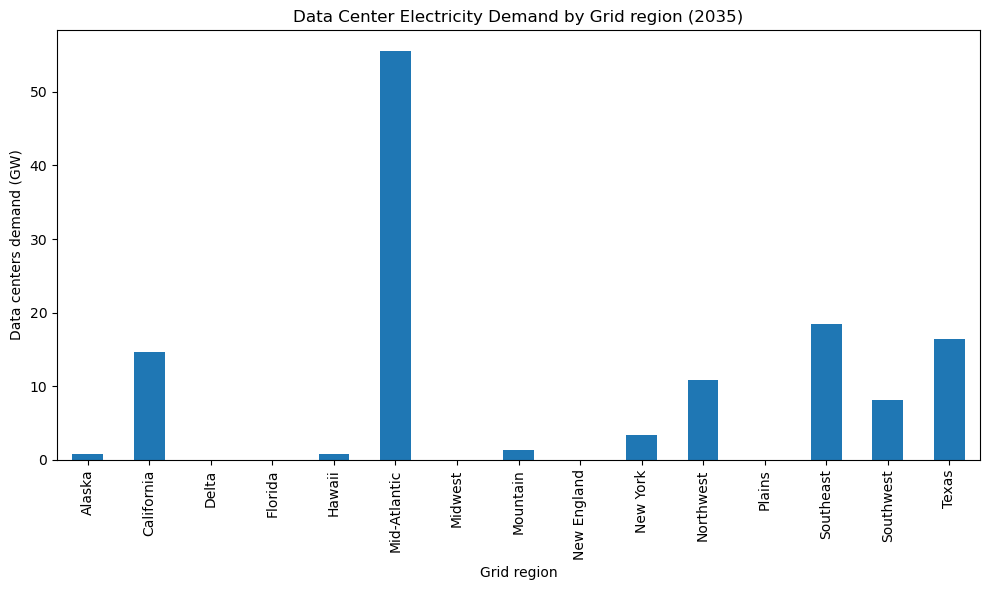

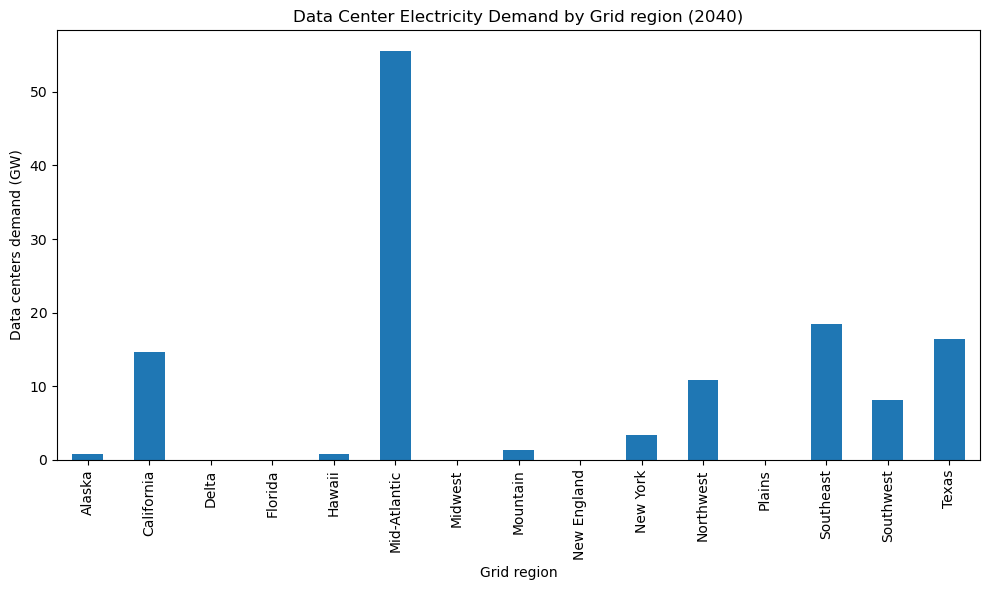

In [16]:
data_center_load = {}
for key, net in networks.items():
    data_center_load[key] = compute_data_center_load(net)

max_val = 0
for df in data_center_load.values():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)
    max_val = max(max_val, demand_by_grid_region.max())

for key, df in data_center_load.items():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)

    # Extract year from key assuming format like "scenario_01_2030"
    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"
    
    ax = demand_by_grid_region.plot(
        kind="bar",
        title=f"Data Center Electricity Demand by Grid region ({year})",
        ylabel="Data centers demand (GW)",
        xlabel="Grid region",
        figsize=(10, 6),
        legend=False
    )
    ax.set_ylim(0, max_val * 1.05)
    plt.tight_layout()
    plt.show()


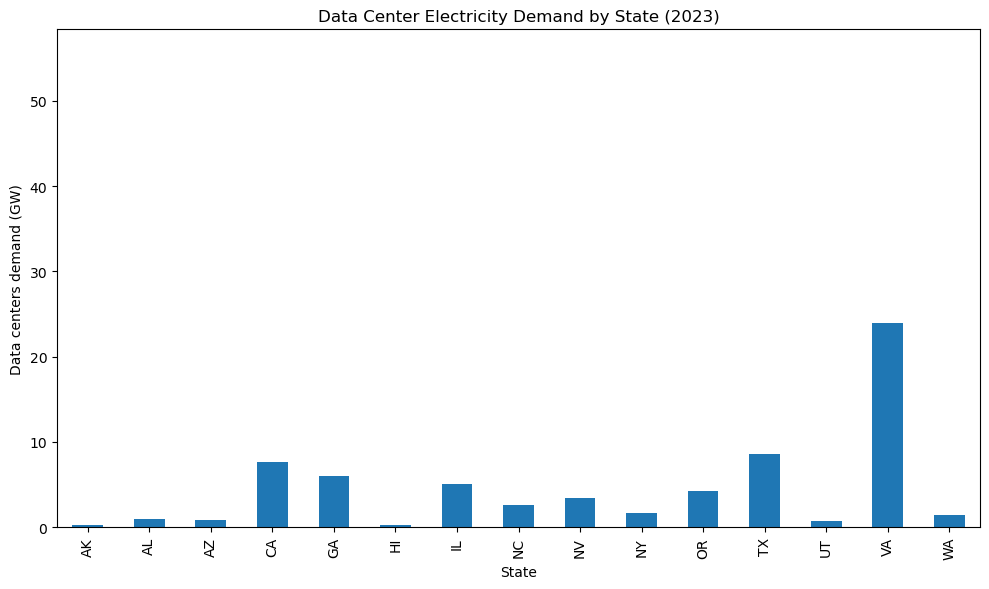

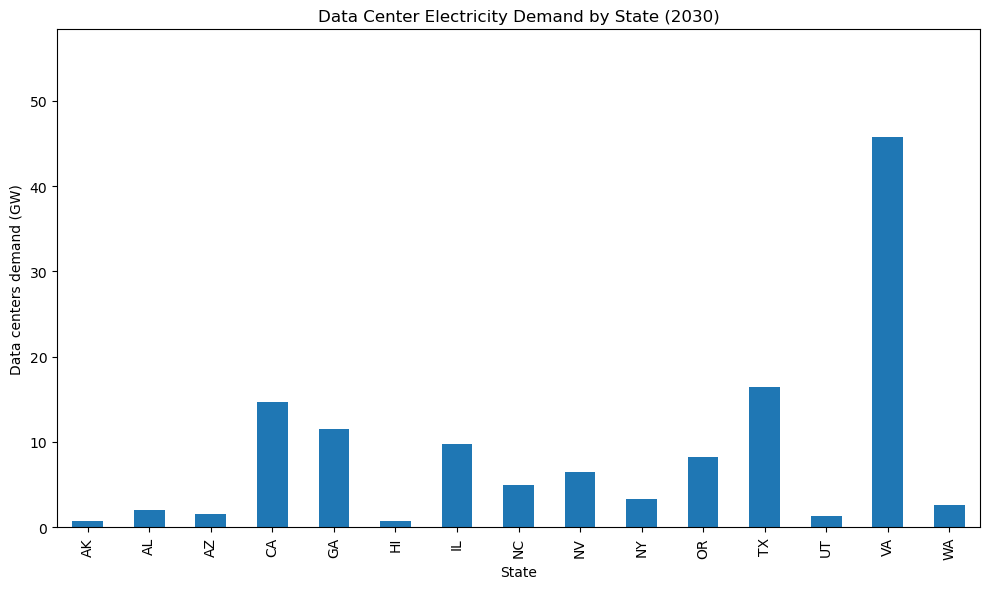

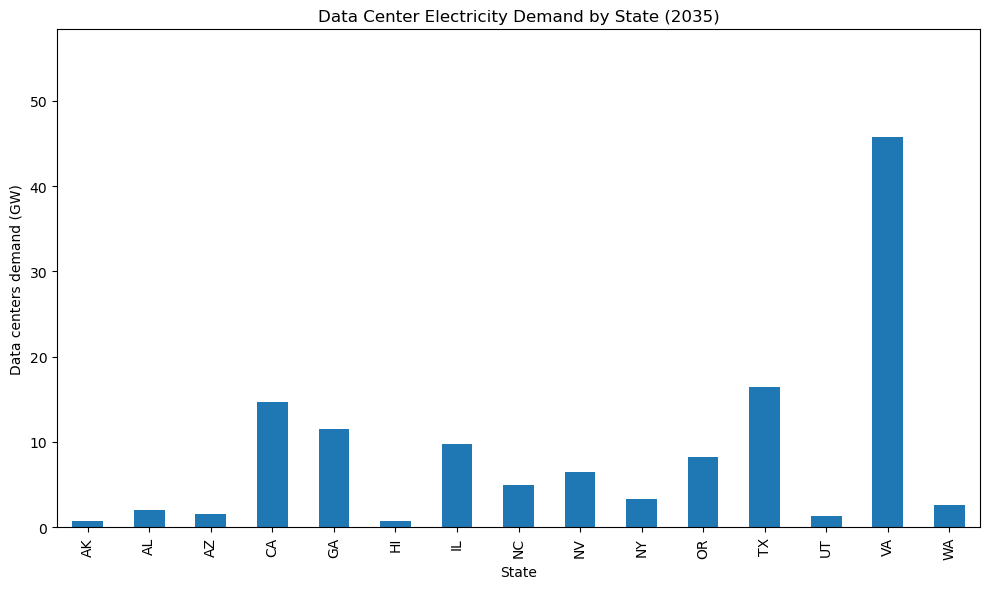

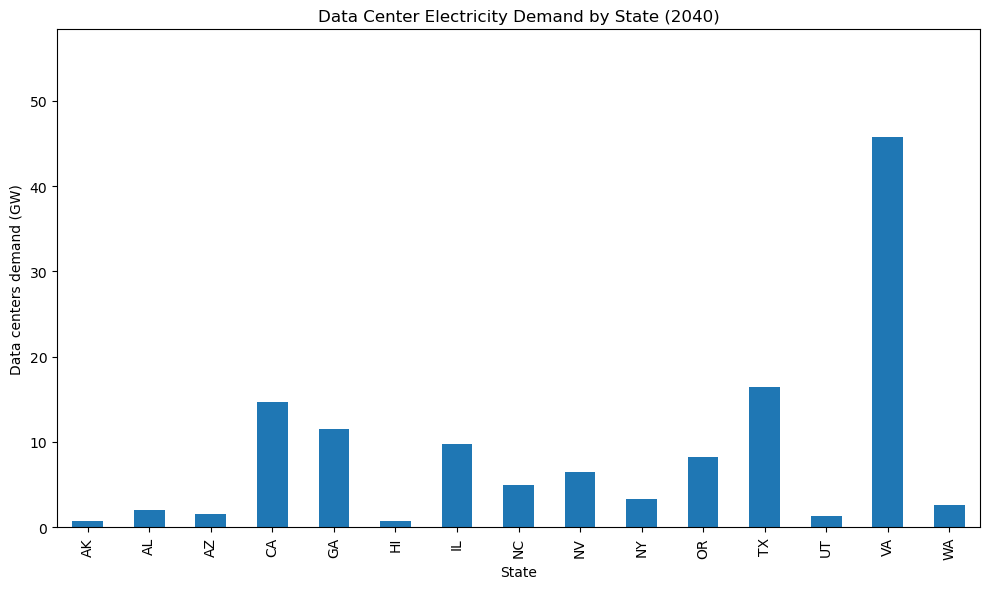

In [17]:
for key, df in data_center_load.items():
    demand_by_state = df.groupby("state")["p_set"].sum().div(1e3)
    demand_by_state = demand_by_state[demand_by_state > 0]

    if demand_by_state.empty:
        print(f"No demand data for {key}")
        continue

    # Extract year from key assuming format like "scenario_01_2030"
    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"

    ax = demand_by_state.plot(
        kind="bar",
        title=f"Data Center Electricity Demand by State ({year})",
        ylabel="Data centers demand (GW)",
        xlabel="State",
        figsize=(10, 6),
        legend=False
    )
    ax.set_ylim(0, max_val * 1.05)
    plt.tight_layout()
    plt.show()

## 3. High-Level Results: System Cost

*This section presents the primary objective function result: the total annualized system cost.*

### 3.1. Total System Cost per Scenario
*A comparison of the total system cost across all analyzed scenarios. This is the key metric for overall economic performance.*

In [18]:
for idx, network in enumerate(networks.keys()):
    carrier_costs = compute_carrier_costs(networks[network], rename_techs).rename(columns={"cost": network_names[idx]}) / 1e9
    if idx == 0:
        total_carrier_costs = carrier_costs
    else:
        total_carrier_costs = total_carrier_costs.join(carrier_costs, how='outer', rsuffix=f'_{idx}')

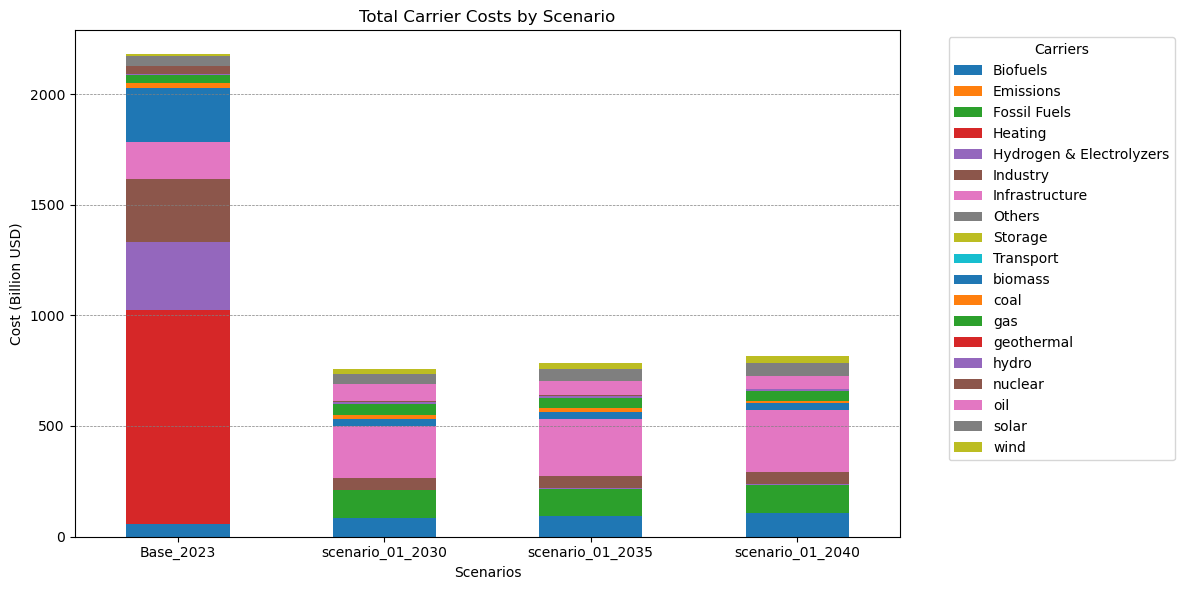

In [19]:
total_carrier_costs.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Total Carrier Costs by Scenario")
plt.ylabel("Cost (Billion USD)")
plt.xlabel("Scenarios")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.legend(title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

## 4. Capacity Analysis: What Was Built?

*Here, we analyze the optimal installed capacities of generation, storage, and conversion technologies as determined by the model.*

### 4.1. Map: Total Installed Electricity Capacity
*A map showing the total installed capacity (in GW) for each electricity generation carrier (e.g., Solar, Onshore Wind, Offshore Wind) at different locations.*

In [20]:
regions_onshore = gpd.read_file(grid_region_shapes_path)

# Prepare Data for Plotting
gen_p_nom_opt = n.generators.groupby(["bus", "carrier"]).p_nom_opt.sum()
sto_p_nom_opt = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt])
bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]

line_values = n.lines.s_nom
links_values = n.links[n.links.carrier == "DC"].p_nom

n = update_ac_dc_bus_coordinates(n)

# Find carriers that need a color
carriers_to_plot = bus_carrier_capacity.index.get_level_values(1).unique()
for carrier in carriers_to_plot:
    if carrier not in n.carriers.index:
        n.add("Carrier", carrier)

for idx in tech_colors.keys():
    n.carriers.loc[idx, "color"] = tech_colors[idx]
    
fill_missing_nice_names(n, nice_names)

# Assign colors from the dictionary, using 'gray' for any not found
n.carriers["color"] = n.carriers.index.map(tech_colors)
n.carriers.color.fillna("gray", inplace=True)

Plotting network: Base_2023


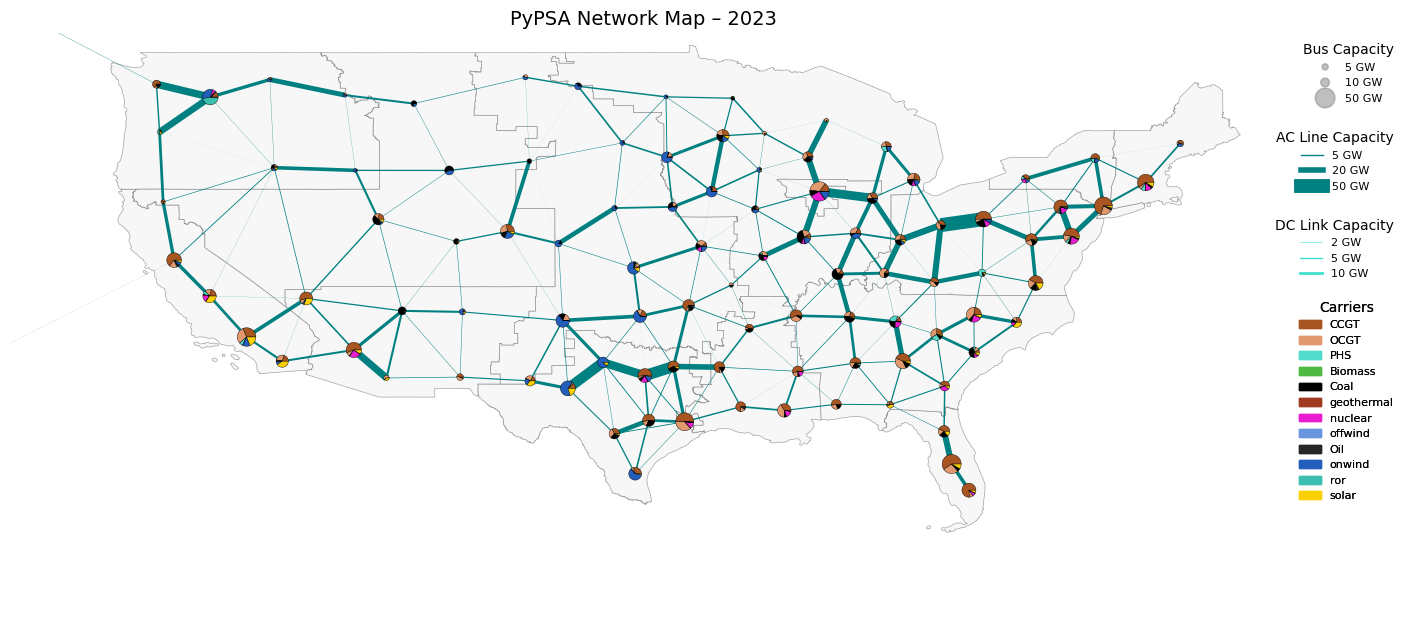

Plotting network: scenario_01_2030


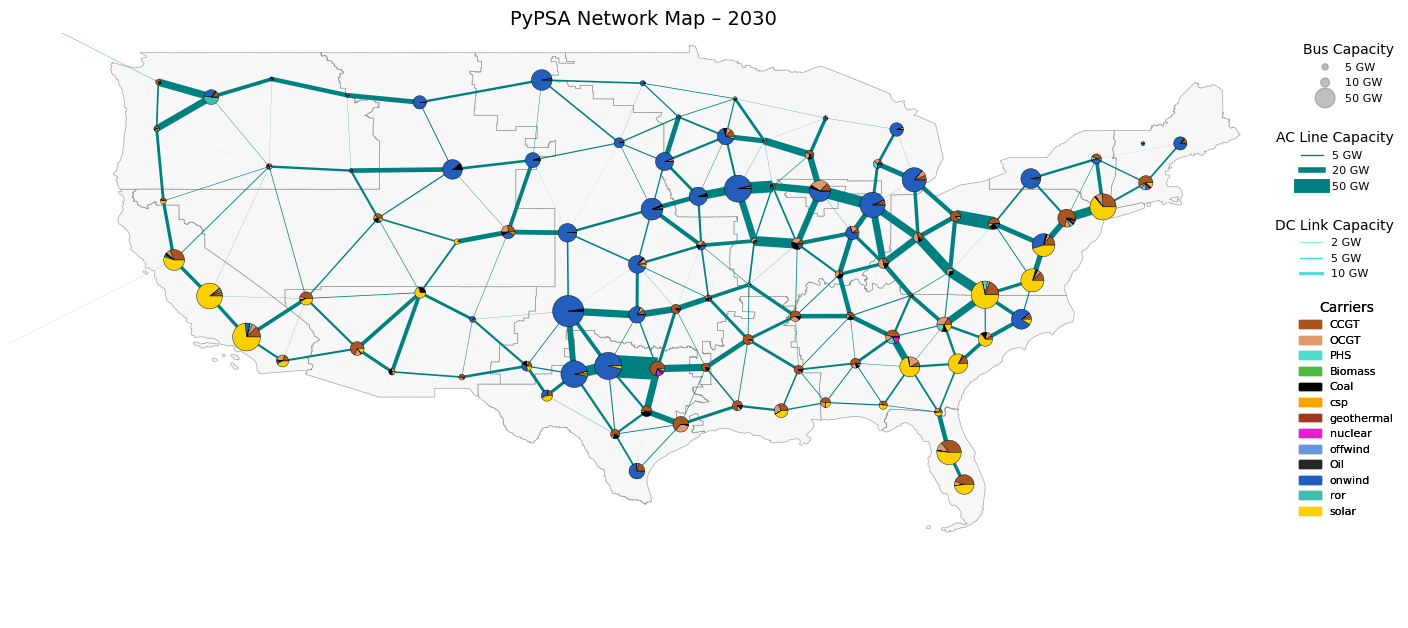

Plotting network: scenario_01_2035


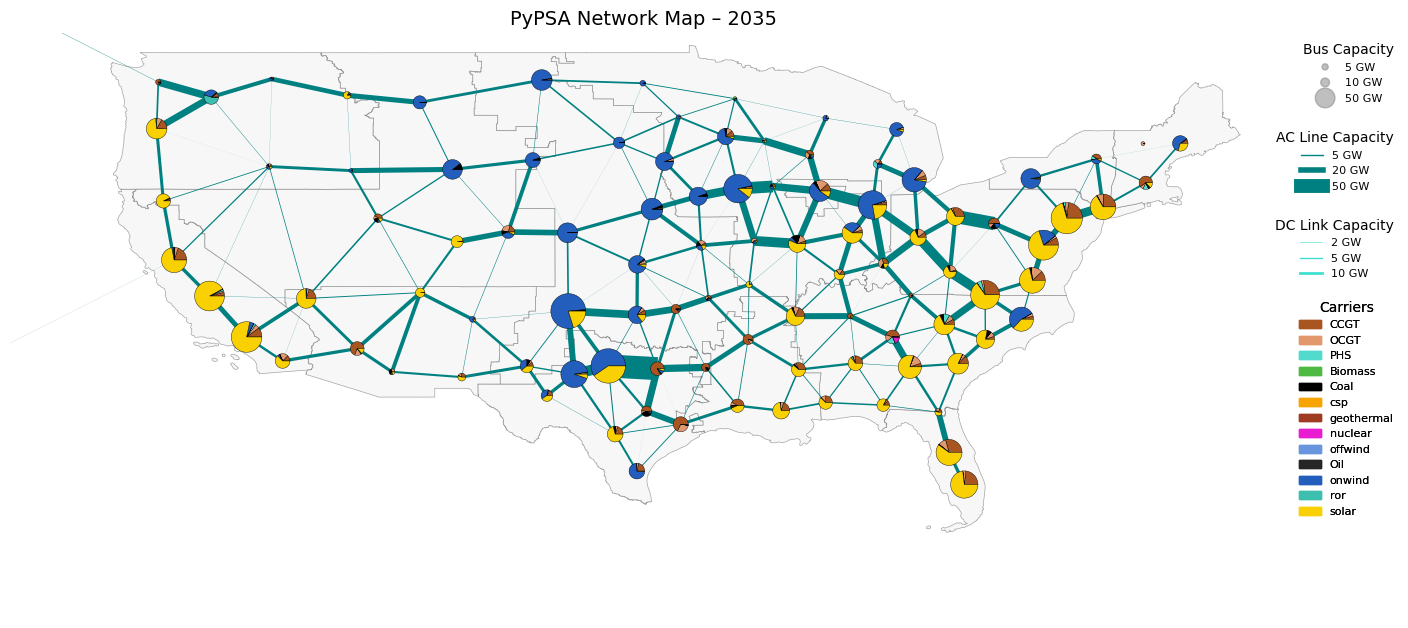

Plotting network: scenario_01_2040


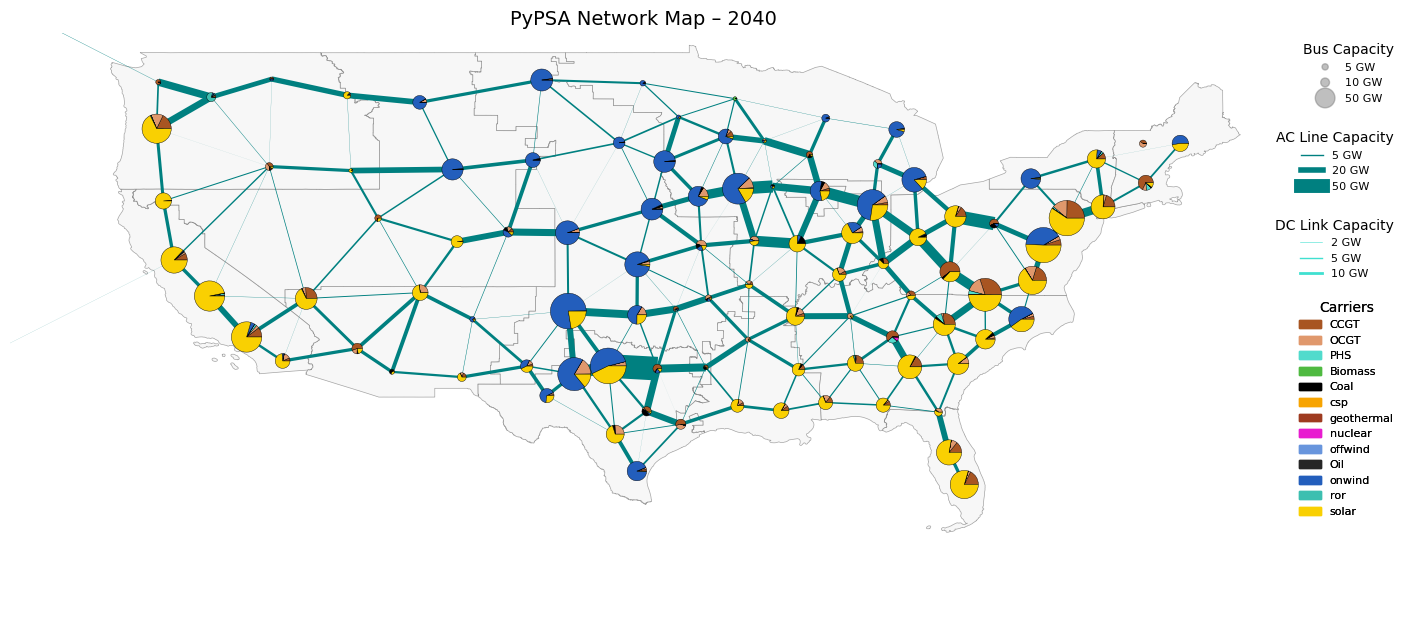

In [21]:
for key, n in networks.items():
    print(f"Plotting network: {key}")
    
    # Electricity generators (or links, using efficiency to scale them)
    gen_carriers = {
        "onwind", "offwind-ac", "offwind-dc", "solar", "solar-rooftop",
        "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam"
    }
    link_carriers = {
        "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
    }
    
    gen_p_nom_opt = n.generators[n.generators.carrier.isin(gen_carriers)]
    gen_p_nom_opt = gen_p_nom_opt.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    sto_p_nom_opt = n.storage_units[n.storage_units.carrier.isin(gen_carriers)]
    sto_p_nom_opt = sto_p_nom_opt.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    link_mask = (
        n.links.efficiency.notnull()
        & (n.links.p_nom_opt > 0)
        & n.links.carrier.isin(link_carriers)
    )
    electricity_links = n.links[link_mask].copy()
    electricity_links["electric_output"] = electricity_links.p_nom_opt * electricity_links.efficiency
    link_p_nom_opt = electricity_links.groupby(["bus1", "carrier"]).electric_output.sum()
    link_p_nom_opt.index = link_p_nom_opt.index.set_names(["bus", "carrier"])
    
    # Join all contributors to electricity generators
    bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt, link_p_nom_opt])
    bus_carrier_capacity = bus_carrier_capacity.groupby(level=[0, 1]).sum()
    bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]
    
    # Valid coordinates for buses
    valid_buses = n.buses.dropna(subset=["x", "y"])
    valid_buses = valid_buses[
        (valid_buses["x"] > -200) & (valid_buses["x"] < 200) &
        (valid_buses["y"] > -90) & (valid_buses["y"] < 90)
    ]
    
    # Merge offwind-ac and offwind-dc into a single 'offwind' category
    bus_carrier_capacity = bus_carrier_capacity.reset_index()
    bus_carrier_capacity['carrier'] = bus_carrier_capacity['carrier'].replace({
        'offwind-ac': 'offwind',
        'offwind-dc': 'offwind'
    })
    bus_carrier_capacity = bus_carrier_capacity.groupby(['bus', 'carrier'], as_index=False).sum()
    bus_carrier_capacity = bus_carrier_capacity.set_index(['bus', 'carrier']).squeeze()

    # Capacity per bus and carrier
    capacity_df = bus_carrier_capacity.unstack(fill_value=0)
    capacity_df = capacity_df.loc[capacity_df.index.intersection(valid_buses.index)]
    
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    bbox = box(-130, 20, -60, 50)
    regions_onshore_clipped = regions_onshore.to_crs(epsg=4326).clip(bbox)
    
    # Setup Map
    regions_onshore_clipped.plot(
        ax=ax,
        facecolor='whitesmoke',
        edgecolor='gray',
        alpha=0.7,
        linewidth=0.5,
        zorder=0,
    )

    # Salva i link originali
    original_links = n.links.copy()
    
    # Filtra i link elettrici in modo sicuro
    n.links = n.links[n.links.index.isin(electricity_links.index)]
    
    # Plot della rete con link filtrati
    line_scale = 5e3
    n.plot(
        ax=ax,
        bus_sizes=0,
        bus_alpha=0,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors='teal',
        link_colors='turquoise',
        color_geomap=False,
        flow=None,
    )
    
    # Ripristina i link originali
    n.links = original_links

    # Pie chart for capacities
    pie_scale = 0.003
    for bus_id, capacities in capacity_df.iterrows():
        x, y = valid_buses.loc[bus_id, ['x', 'y']]
        if not bbox.contains(gpd.points_from_xy([x], [y])[0]):
            continue
    
        values = capacities.values
        total = values.sum()
        if total == 0:
            continue
    
        size = np.clip(np.sqrt(total) * pie_scale, 0.1, 1.5)
        colors = [tech_colors.get(c, 'gray') for c in capacities.index]
    
        start_angle = 0
        for val, color in zip(values, colors):
            if val == 0:
                continue
            angle = 360 * val / total  # proporzione rispetto al totale del nodo
            wedge = Wedge(
                center=(x, y),
                r=size,
                theta1=start_angle,
                theta2=start_angle + angle,
                facecolor=color,
                edgecolor='k',
                linewidth=0.3,
                transform=ccrs.PlateCarree()._as_mpl_transform(ax),
                zorder=5,
            )
            ax.add_patch(wedge)
            start_angle += angle
            
    class HandlerCircle(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height, fontsize, trans):
            center = (width / 2, height / 2)
            radius = orig_handle.get_radius()
            p = plt.Circle(center, radius)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]
    
    # Legends
    bus_caps = [5, 10, 50]
    bus_patches = []
    for cap in bus_caps:
        r_in_map = np.sqrt(cap)
        r_pts = r_in_map * fig.dpi * 2
        circ = plt.Circle((0, 0), radius=r_pts / 2 / fig.dpi, color='gray', alpha=0.5)
        bus_patches.append(circ)
    
    bus_legend = ax.legend(
        bus_patches,
        [f"{cap} GW" for cap in bus_caps],
        title="Bus Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        handler_map={mpatches.Circle: HandlerCircle()},
        loc='upper right',
        bbox_to_anchor=(1.1, 1.0)
    )
    
    ac_caps = [5e3, 20e3, 50e3]
    ac_patches = [
        mlines.Line2D([], [], color='teal', linewidth=cap / line_scale, label=f"{int(cap/1e3)} GW")
        for cap in ac_caps
    ]
    ac_legend = ax.legend(
        handles=ac_patches,
        title="AC Line Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.85)
    )
    
    dc_caps = [2e3, 5e3, 10e3]
    dc_patches = [
        mlines.Line2D([], [], color='turquoise', linewidth=cap / line_scale, label=f"{int(cap/1e3)} GW")
        for cap in dc_caps
    ]
    dc_legend = ax.legend(
        handles=dc_patches,
        title="DC Link Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.70)
    )
    
    carrier_handles = [
        mpatches.Patch(color=tech_colors.get(c, 'gray'), label=nice_names.get(c, c))
        for c in sorted(capacity_df.columns) if capacity_df[c].sum() > 0
    ]
    carrier_legend = ax.legend(
        handles=carrier_handles,
        title="Carriers",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.56),
        ncol=1
    )
    
    ax.add_artist(bus_legend)
    ax.add_artist(ac_legend)
    ax.add_artist(dc_legend)
    ax.add_artist(carrier_legend)
        
    ax.set_extent([-130, -65, 20, 50], crs=ccrs.PlateCarree())
    ax.autoscale(False)
    
    year = key[-4:]  # Extract the year
    ax.set_title(f"PyPSA Network Map – {year}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

In [22]:
totals_by_carrier = {}

for name, net in networks.items():
    # Define carriers used in the plot
    gen_carriers = {
        "onwind", "offwind-ac", "offwind-dc", "solar", "solar-rooftop",
        "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam"
    }
    link_carriers = {
        "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
    }

    # Generators
    gen = net.generators.copy()
    gen['carrier'] = gen['carrier'].replace({'offwind-ac': 'offwind', 'offwind-dc': 'offwind'})
    gen = gen[gen.carrier.isin(gen_carriers)]
    gen_totals = gen.groupby('carrier')['p_nom_opt'].sum()

    # Storage
    sto = net.storage_units.copy()
    sto = sto[sto.carrier.isin(gen_carriers)]
    sto_totals = sto.groupby('carrier')['p_nom_opt'].sum()

    # Links (output side scaled by efficiency)
    links = net.links.copy()
    mask = (
        links.efficiency.notnull()
        & (links.p_nom_opt > 0)
        & links.carrier.isin(link_carriers)
    )
    links = links[mask]
    links_totals = links.groupby('carrier').apply(
        lambda df: (df['p_nom_opt'] * df['efficiency']).sum()
    )

    # Combine all
    all_totals = pd.concat([gen_totals, sto_totals, links_totals])
    all_totals = all_totals.groupby(all_totals.index).sum()  # Merge duplicates
    all_totals = all_totals[all_totals > 0]
    totals_by_carrier[name] = all_totals

# Build dataframe
carrier_capacity_df = pd.DataFrame(totals_by_carrier).fillna(0)

# Convert MW → GW
carrier_capacity_df = carrier_capacity_df / 1000
carrier_capacity_df = carrier_capacity_df.round(2)

# Filter: only keep rows with at least one nonzero value
carrier_capacity_df = carrier_capacity_df.loc[carrier_capacity_df.sum(axis=1) > 0]

# Add label
carrier_capacity_df.index.name = "carrier (GW)"

# Display
from IPython.display import display
display(carrier_capacity_df)


Base_2023  scenario_01_2030  scenario_01_2035  scenario_01_2040
carrier (GW)                                                                 
CCGT             300.00            287.39            289.28            248.44
OCGT             167.94            137.61            130.16            182.48
PHS               21.98             21.98             21.98             21.98
biomass            3.07              2.22              2.05              1.64
coal             109.89             43.44             33.45             23.88
geothermal         1.29              1.19              1.10              0.82
nuclear           52.40              7.35              2.54              1.27
oil                8.04              3.41              2.19              0.32
onwind           132.76            722.74            729.65            824.25
ror                9.87              9.60              9.60              6.07
solar             60.39            375.34            899.68           1112.05

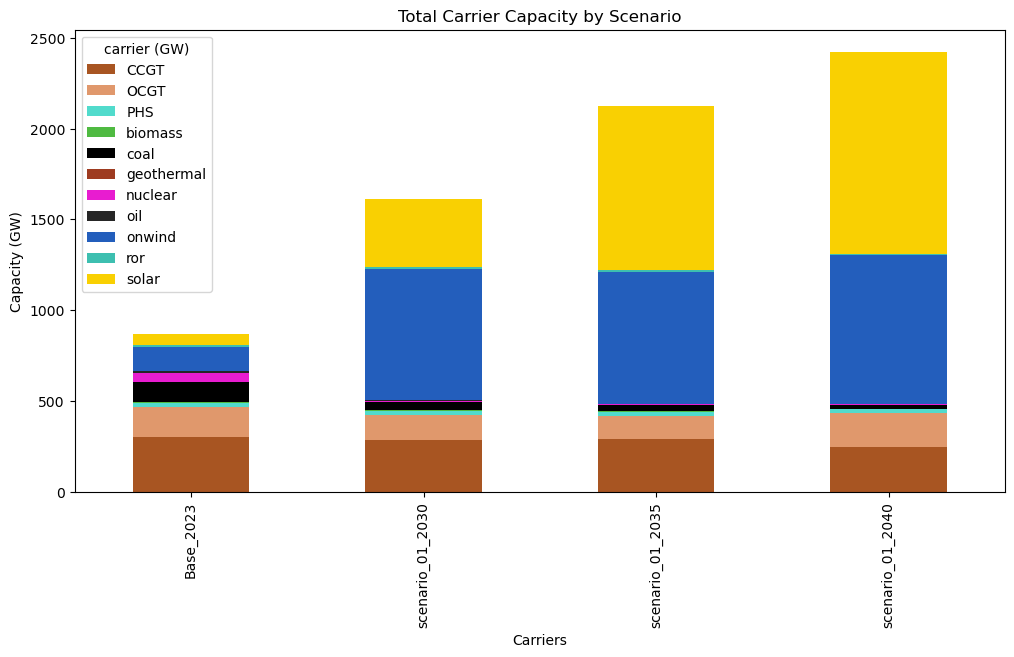

In [23]:
carrier_order = list(carrier_capacity_df.index)
color_list = [tech_colors.get(carrier, 'gray') for carrier in carrier_order]

carrier_capacity_df.T.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    title="Total Carrier Capacity by Scenario",
    ylabel="Capacity (GW)",
    xlabel="Carriers",
    color=color_list,
)
plt.show()

### 4.2. Map: Total Installed Hydrogen Electrolyzer Capacity
*This map visualizes the spatial distribution and total capacity (in GW) of different electrolyzer technologies (e.g., AEL, PEM).*

Plotting H2 capacities for Base_2023...


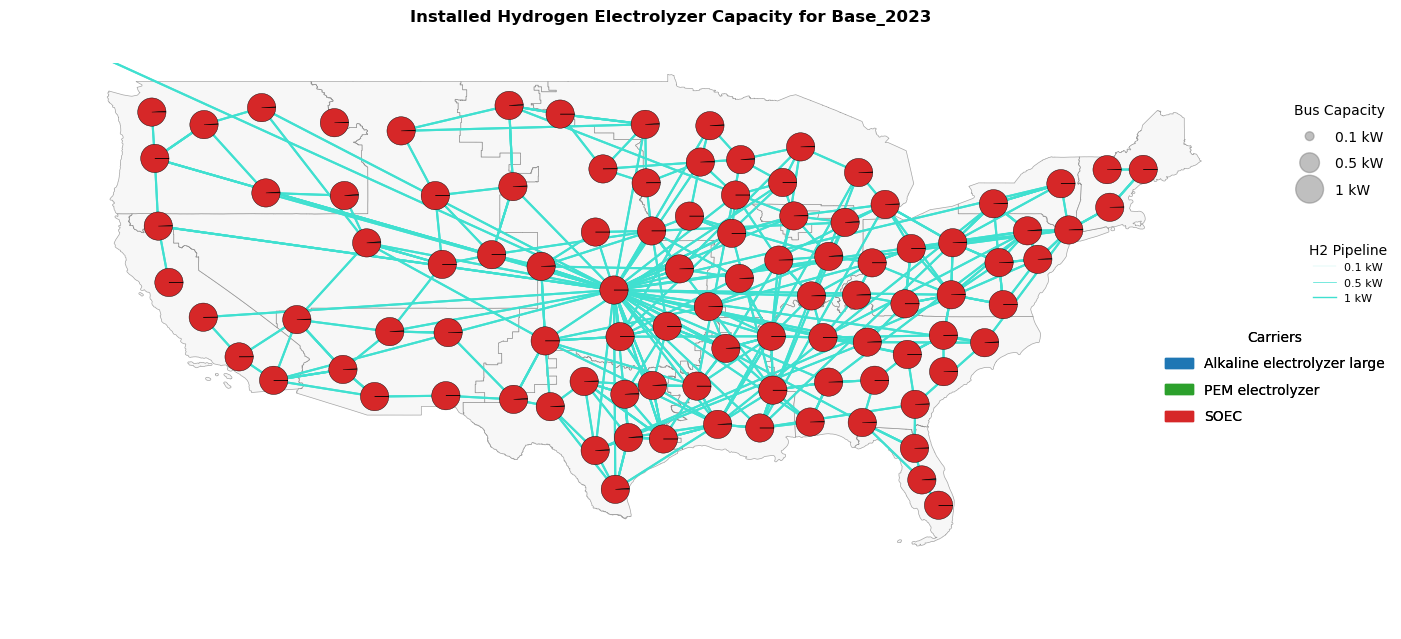

Plotting H2 capacities for scenario_01_2030...


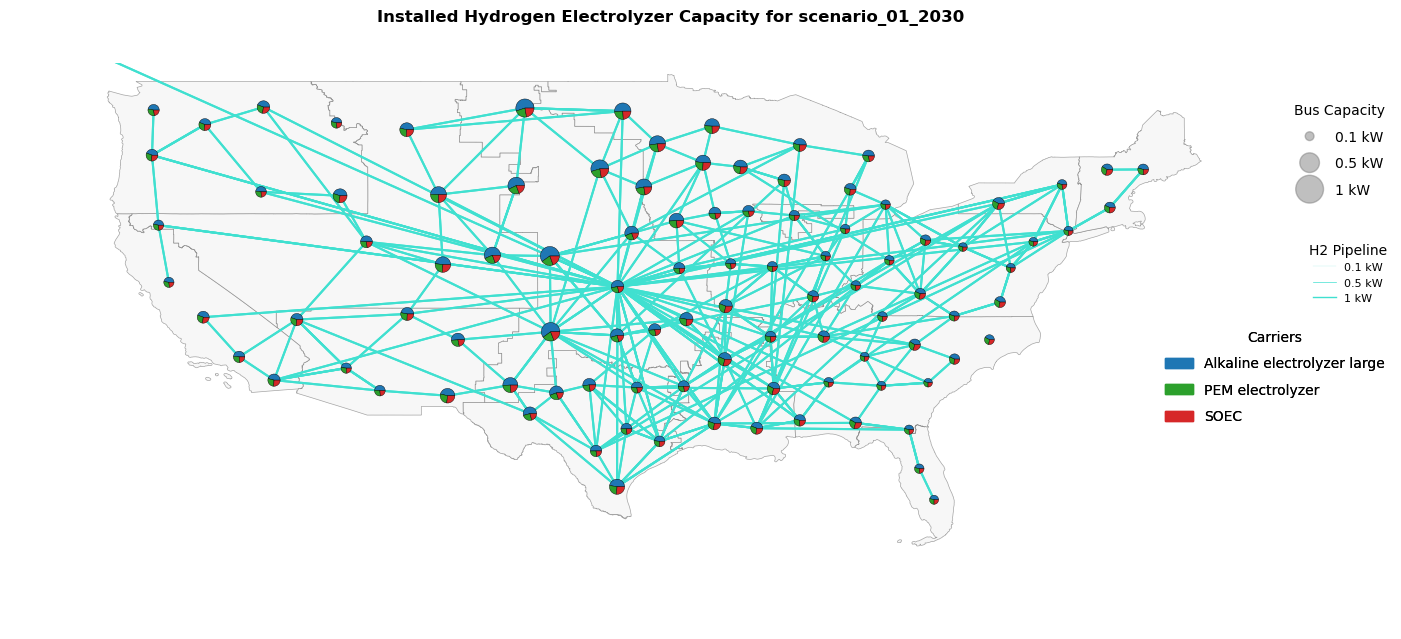

Plotting H2 capacities for scenario_01_2035...


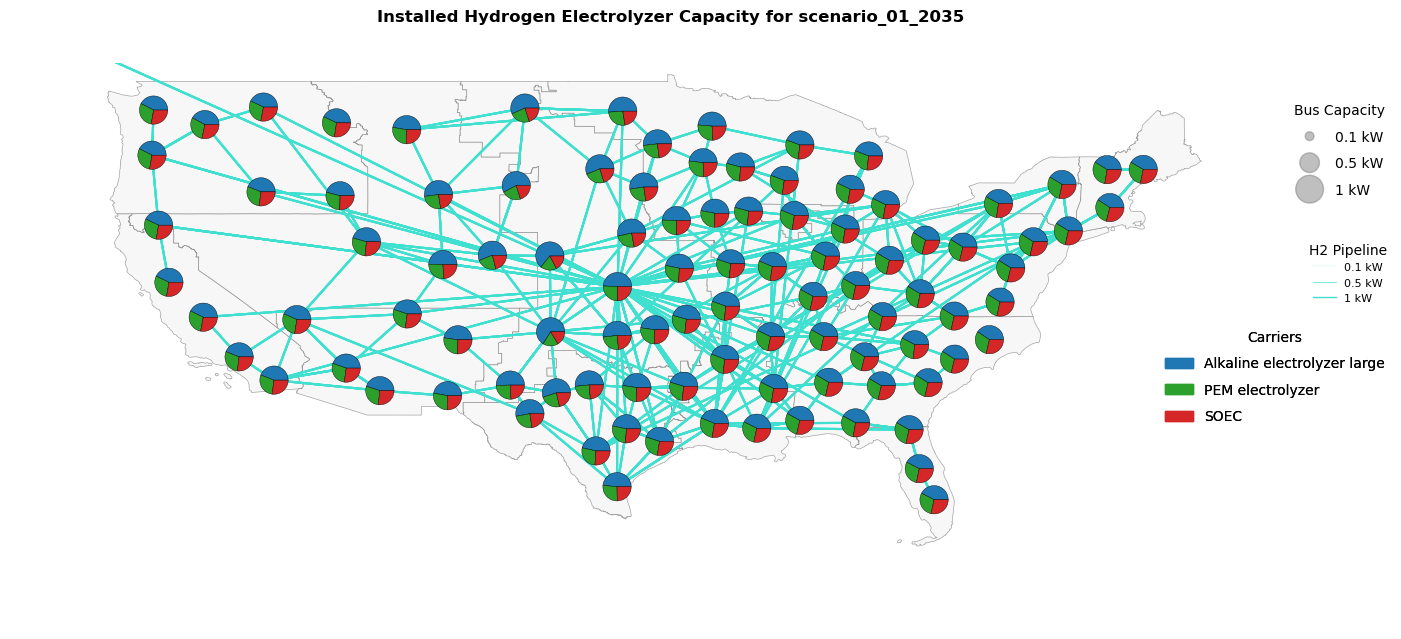

Plotting H2 capacities for scenario_01_2040...


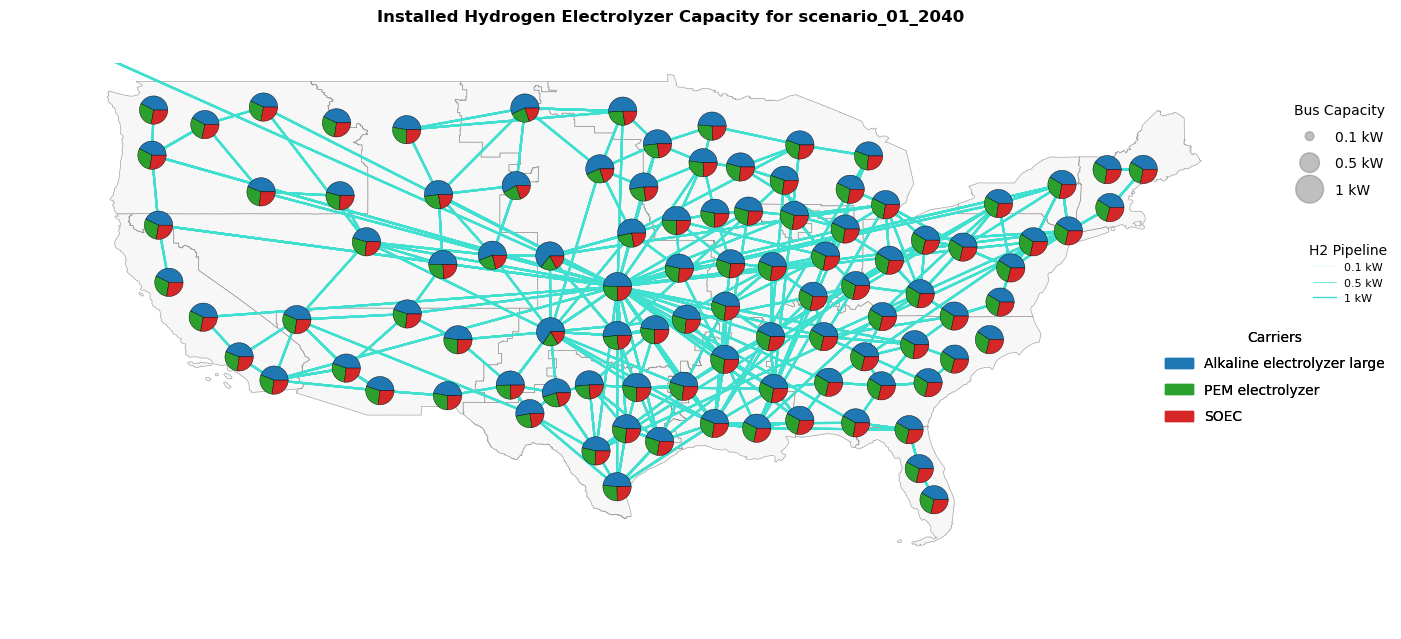

In [24]:
for idx, network in enumerate(networks.keys()):
    print(f"Plotting H2 capacities for {network}...")
    plot_h2_capacities_map(networks[network], network, tech_colors, nice_names, regions_onshore)

Plotting H2 capacities bar chart for Base_2023...


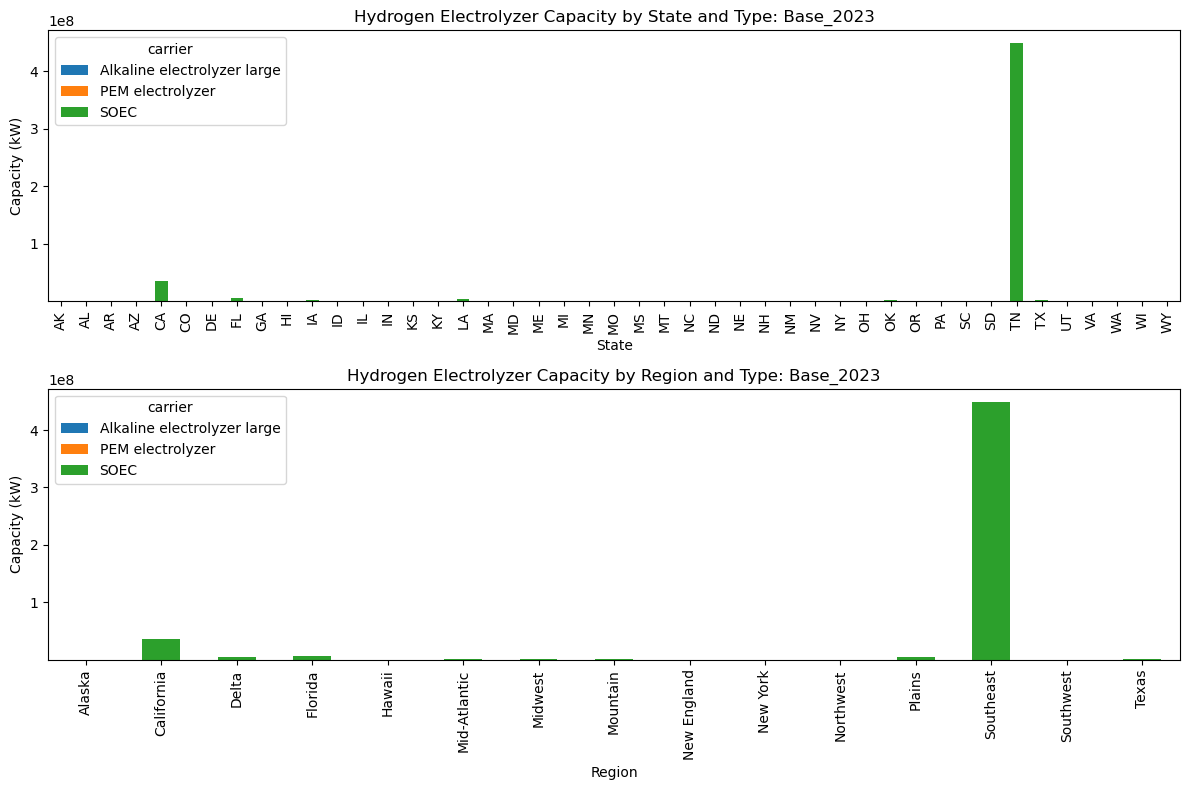

Plotting H2 capacities bar chart for scenario_01_2030...


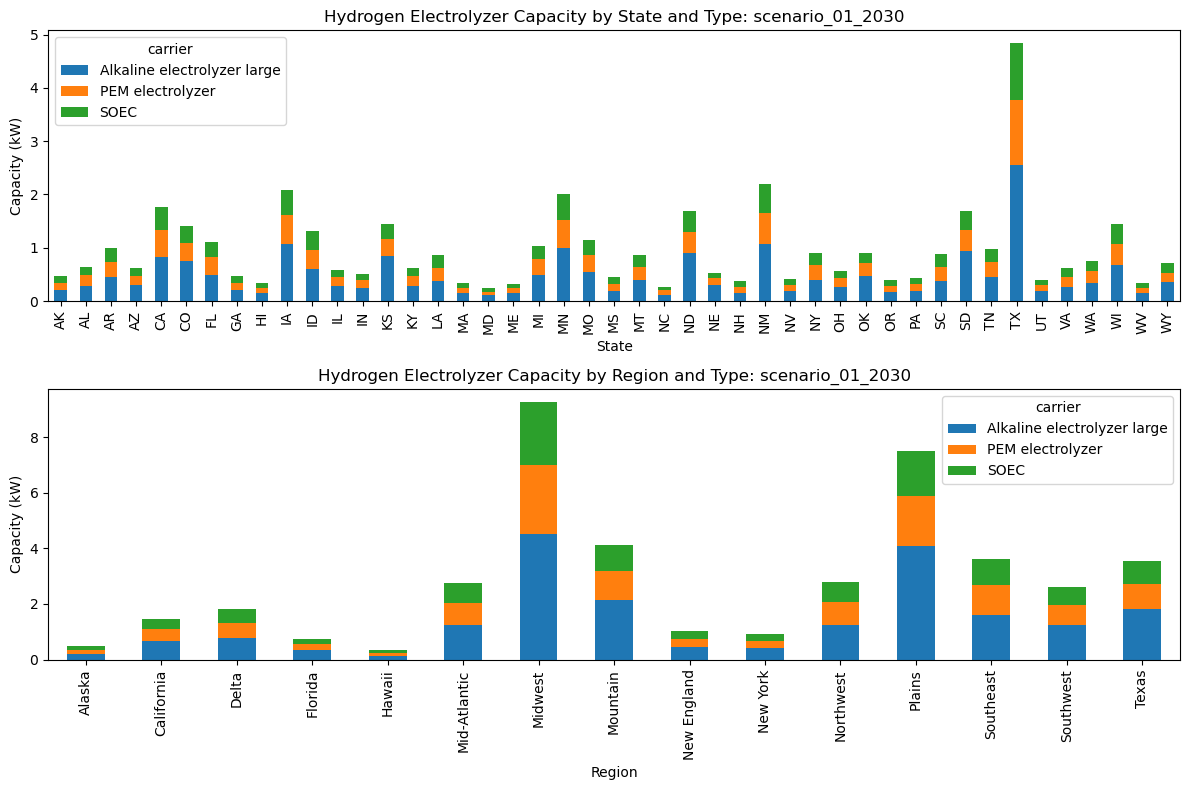

Plotting H2 capacities bar chart for scenario_01_2035...


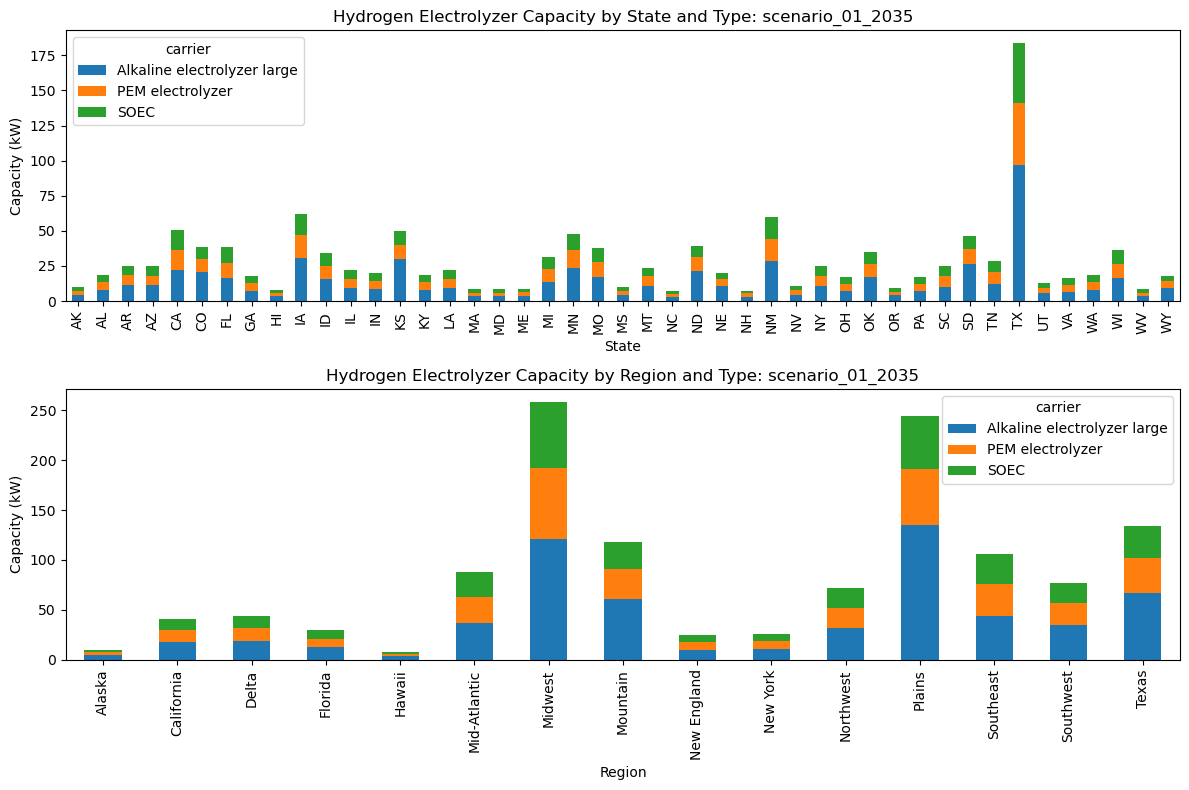

Plotting H2 capacities bar chart for scenario_01_2040...


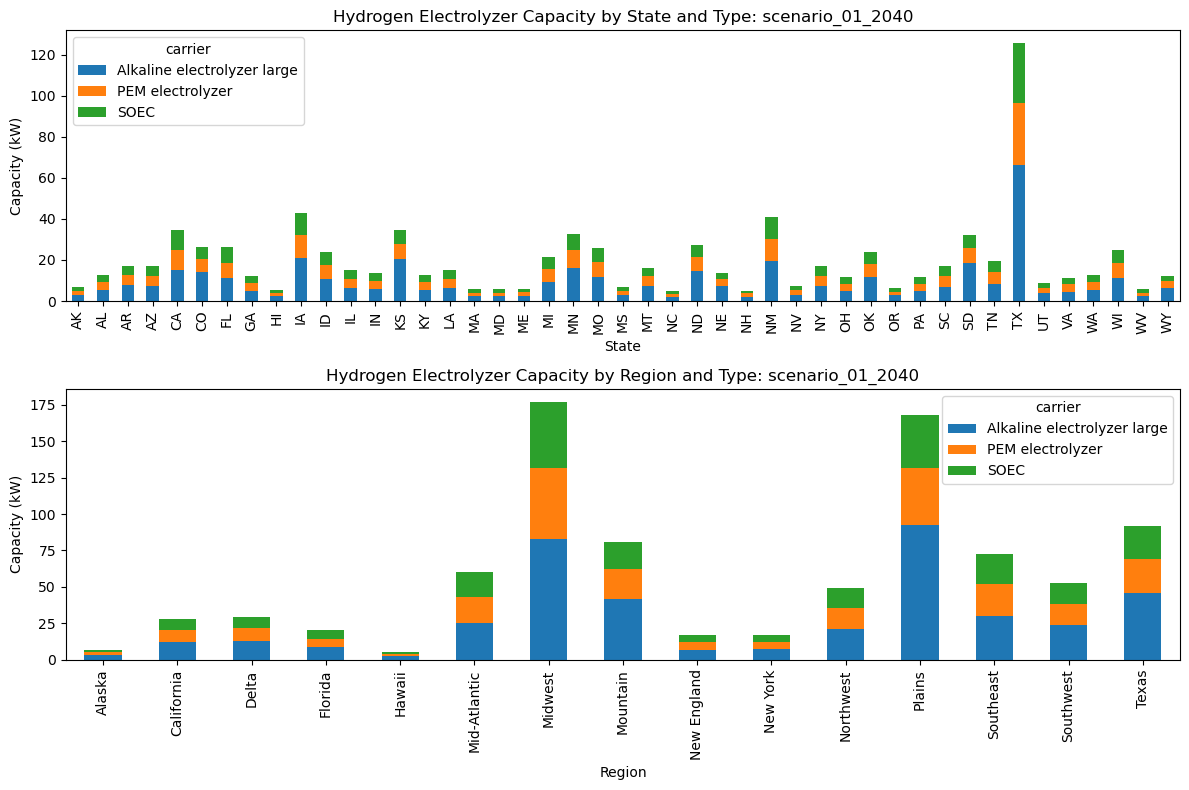

In [25]:
for idx, network in enumerate(networks.keys()):
    print(f"Plotting H2 capacities bar chart for {network}...")
    plot_h2_capacities_bar(networks[network], network)

In [26]:
for idx, network in enumerate(networks.keys()):
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['state'])[['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']].sum().round(2)
    print(f"Hydrogen capacities for {network}:")
    from IPython.display import display
    display(h2_state_cap.sort_values(by=list(h2_state_cap.columns), ascending=False).T)

Hydrogen capacities for Base_2023:


state                                TX           CA       MN          FL  \
carrier                                                                     
Alkaline electrolyzer large       78.37        44.39    33.43       27.29   
PEM electrolyzer                  32.92        18.33    14.11       11.52   
SOEC                         1269834.04  35999181.21  6352.34  5761147.84   

state                                  TN       MO        NY          IA  \
carrier                                                                    
Alkaline electrolyzer large  2.695000e+01    26.91     26.82       26.73   
PEM electrolyzer             1.123000e+01    11.22     11.14       11.25   
SOEC                         4.488506e+08  5444.31  29883.33  1329260.01   

state                             NM          LA  ...       ME      AK  \
carrier                                           ...                    
Alkaline electrolyzer large    26.25       26.16  ...     8.96    8.54   
PEM electrolyzer               11.11       10.95  ...     3.82    3.60   
SOEC                         7028.09  4521206.74  ...  6477.38  640.84   

state                               WY         MS        OR       NV       MA  \
carrier                                                                         
Alkaline electrolyzer large       8.41       8.40      8.18     8.17     8.15   
PEM electrolyzer                  3.53       3.53      3.36     3.44     3.39   
SOEC                         174492.97  422579.35  84289.69  1511.50  2245.02   

state                            AR       NH       HI  
carrier                                                
Alkaline electrolyzer large    8.10     7.94     7.04  
PEM electrolyzer               3.39     3.47     3.46  
SOEC                         970.47  1936.04  1553.79  

[3 rows x 45 columns]

Hydrogen capacities for scenario_01_2030:


state                          TX    IA    NM    MN    SD    ND    KS    CA  \
carrier                                                                       
Alkaline electrolyzer large  2.55  1.08  1.07  1.00  0.94  0.90  0.84  0.82   
PEM electrolyzer             1.21  0.54  0.59  0.51  0.39  0.40  0.32  0.51   
SOEC                         1.07  0.47  0.54  0.49  0.35  0.39  0.29  0.44   

state                          CO    WI  ...    PA    NV    OR    NH    ME  \
carrier                                  ...                                 
Alkaline electrolyzer large  0.74  0.68  ...  0.19  0.19  0.17  0.15  0.15   
PEM electrolyzer             0.35  0.40  ...  0.13  0.12  0.11  0.11  0.10   
SOEC                         0.32  0.37  ...  0.11  0.11  0.10  0.11  0.08   

state                          HI    MA    WV    NC    MD  
carrier                                                    
Alkaline electrolyzer large  0.14  0.14  0.14  0.11  0.11  
PEM electrolyzer             0.10  0.10  0.10  0.08  0.07  
SOEC                         0.10  0.09  0.09  0.07  0.06  

[3 rows x 45 columns]

Hydrogen capacities for scenario_01_2035:


state                           TX     IA     KS     NM     SD     MN     CA  \
carrier                                                                        
Alkaline electrolyzer large  96.75  30.60  29.60  28.43  26.51  23.56  21.90   
PEM electrolyzer             44.58  16.47  10.50  15.99  10.61  12.60  14.78   
SOEC                         42.32  15.28   9.89  15.09   9.38  11.25  13.85   

state                           ND     CO     OK  ...    AK    MS    OR    ME  \
carrier                                           ...                           
Alkaline electrolyzer large  21.45  20.60  17.34  ...  4.37  4.26  3.97  3.65   
PEM electrolyzer              9.75   9.44   8.89  ...  2.98  2.96  2.79  2.63   
SOEC                          8.30   8.56   8.42  ...  2.72  2.73  2.59  2.47   

state                          WV    MD    HI    MA    NH    NC  
carrier                                                          
Alkaline electrolyzer large  3.48  3.45  3.43  3.39  3.07  2.99  
PEM electrolyzer             2.55  2.53  2.47  2.51  2.33  2.26  
SOEC                         2.38  2.40  2.14  2.40  2.06  2.10  

[3 rows x 45 columns]

Hydrogen capacities for scenario_01_2040:


state                           TX     IA     KS     NM     SD     MN     CA  \
carrier                                                                        
Alkaline electrolyzer large  66.07  20.99  20.53  19.43  18.41  16.16  14.96   
PEM electrolyzer             30.55  11.31   7.24  10.96   7.32   8.65  10.12   
SOEC                         28.91  10.46   6.80  10.31   6.45   7.70   9.46   

state                           ND     CO     OK  ...    AK    MS    OR    ME  \
carrier                                           ...                           
Alkaline electrolyzer large  14.80  14.10  11.84  ...  2.98  2.90  2.72  2.50   
PEM electrolyzer              6.71   6.48   6.09  ...  2.04  2.02  1.91  1.81   
SOEC                          5.70   5.86   5.74  ...  1.86  1.86  1.78  1.69   

state                          WV    MD    HI    MA    NH    NC  
carrier                                                          
Alkaline electrolyzer large  2.38  2.36  2.35  2.32  2.10  2.05  
PEM electrolyzer             1.75  1.73  1.69  1.72  1.60  1.55  
SOEC                         1.63  1.64  1.47  1.64  1.41  1.44  

[3 rows x 45 columns]

In [27]:
for idx, network in enumerate(networks.keys()):
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['region'])[['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']].sum().round(2)
    print(f"Hydrogen capacities for {network}:")
    from IPython.display import display
    display(h2_state_cap.sort_values(by=list(h2_state_cap.columns), ascending=False).T)

Hydrogen capacities for Base_2023:


region                          Midwest     Southeast      Plains  \
carrier                                                             
Alkaline electrolyzer large      156.02  1.052700e+02      104.09   
PEM electrolyzer                  65.40  4.421000e+01       43.73   
SOEC                         1653002.81  4.495236e+08  4516614.11   

region                       Mid-Atlantic      Texas   Mountain  Northwest  \
carrier                                                                      
Alkaline electrolyzer large         96.41      70.05      62.11      58.60   
PEM electrolyzer                    40.30      29.42      25.98      24.94   
SOEC                           1089788.00  880418.94  332086.61   91703.94   

region                       Southwest       Delta   California     Florida  \
carrier                                                                       
Alkaline electrolyzer large      51.53       42.66        35.09       27.29   
PEM electrolyzer                 21.78       17.87        14.47       11.52   
SOEC                          12968.78  4944756.56  35997122.07  5761147.84   

region                       New York  New England  Alaska   Hawaii  
carrier                                                              
Alkaline electrolyzer large     26.82        25.05    8.54     7.04  
PEM electrolyzer                11.14        10.68    3.60     3.46  
SOEC                         29883.33     10658.44  640.84  1553.79

Hydrogen capacities for scenario_01_2030:


region                       Midwest  Plains  Mountain  Texas  Southeast  \
carrier                                                                    
Alkaline electrolyzer large     4.52    4.10      2.13   1.80       1.60   
PEM electrolyzer                2.50    1.79      1.06   0.92       1.07   
SOEC                            2.26    1.61      0.95   0.81       0.95   

region                       Northwest  Southwest  Mid-Atlantic  Delta  \
carrier                                                                  
Alkaline electrolyzer large       1.26       1.24          1.23   0.79   
PEM electrolyzer                  0.80       0.72          0.82   0.51   
SOEC                              0.71       0.65          0.70   0.50   

region                       California  New England  New York  Florida  \
carrier                                                                   
Alkaline electrolyzer large        0.68         0.44      0.40     0.33   
PEM electrolyzer                   0.42         0.31      0.27     0.21   
SOEC                               0.37         0.27      0.24     0.18   

region                       Alaska  Hawaii  
carrier                                      
Alkaline electrolyzer large    0.21    0.14  
PEM electrolyzer               0.14    0.10  
SOEC                           0.13    0.10

Hydrogen capacities for scenario_01_2035:


region                       Plains  Midwest  Texas  Mountain  Southeast  \
carrier                                                                    
Alkaline electrolyzer large  134.62   120.65  66.90     60.91      44.08   
PEM electrolyzer              56.95    71.75  34.56     29.79      31.78   
SOEC                          52.78    66.15  32.89     27.33      29.96   

region                       Mid-Atlantic  Southwest  Northwest  Delta  \
carrier                                                                  
Alkaline electrolyzer large         36.47      34.89      31.22  18.81   
PEM electrolyzer                    26.31      21.37      21.01  12.65   
SOEC                                24.86      20.21      19.63  11.93   

region                       California  Florida  New York  New England  \
carrier                                                                   
Alkaline electrolyzer large       17.85    12.45     10.47        10.11   
PEM electrolyzer                  11.97     8.66      7.70         7.48   
SOEC                              11.25     8.38      7.07         6.93   

region                       Alaska  Hawaii  
carrier                                      
Alkaline electrolyzer large    4.37    3.43  
PEM electrolyzer               2.98    2.47  
SOEC                           2.72    2.14

Hydrogen capacities for scenario_01_2040:


region                       Plains  Midwest  Texas  Mountain  Southeast  \
carrier                                                                    
Alkaline electrolyzer large   92.52    82.69  45.70     41.92      30.12   
PEM electrolyzer              39.12    49.23  23.67     20.46      21.75   
SOEC                          36.15    45.26  22.46     18.72      20.43   

region                       Mid-Atlantic  Southwest  Northwest  Delta  \
carrier                                                                  
Alkaline electrolyzer large         24.96      23.85      21.37  12.82   
PEM electrolyzer                    18.03      14.64      14.41   8.64   
SOEC                                16.98      13.81      13.42   8.13   

region                       California  Florida  New York  New England  \
carrier                                                                   
Alkaline electrolyzer large       12.19     8.50      7.15         6.92   
PEM electrolyzer                   8.20     5.92      5.27         5.12   
SOEC                               7.68     5.71      4.82         4.73   

region                       Alaska  Hawaii  
carrier                                      
Alkaline electrolyzer large    2.98    2.35  
PEM electrolyzer               2.04    1.69  
SOEC                           1.86    1.47

### 4.3. Map: Total Installed Fischer-Tropsch (FT) Capacity
*A map showing where FT synthesis plants are built and their respective capacities, crucial for e-kerosene production.*

Plotting FT map for: Base_2023
Plotting FT map for: scenario_01_2030
Plotting FT map for: scenario_01_2035
Plotting FT map for: scenario_01_2040


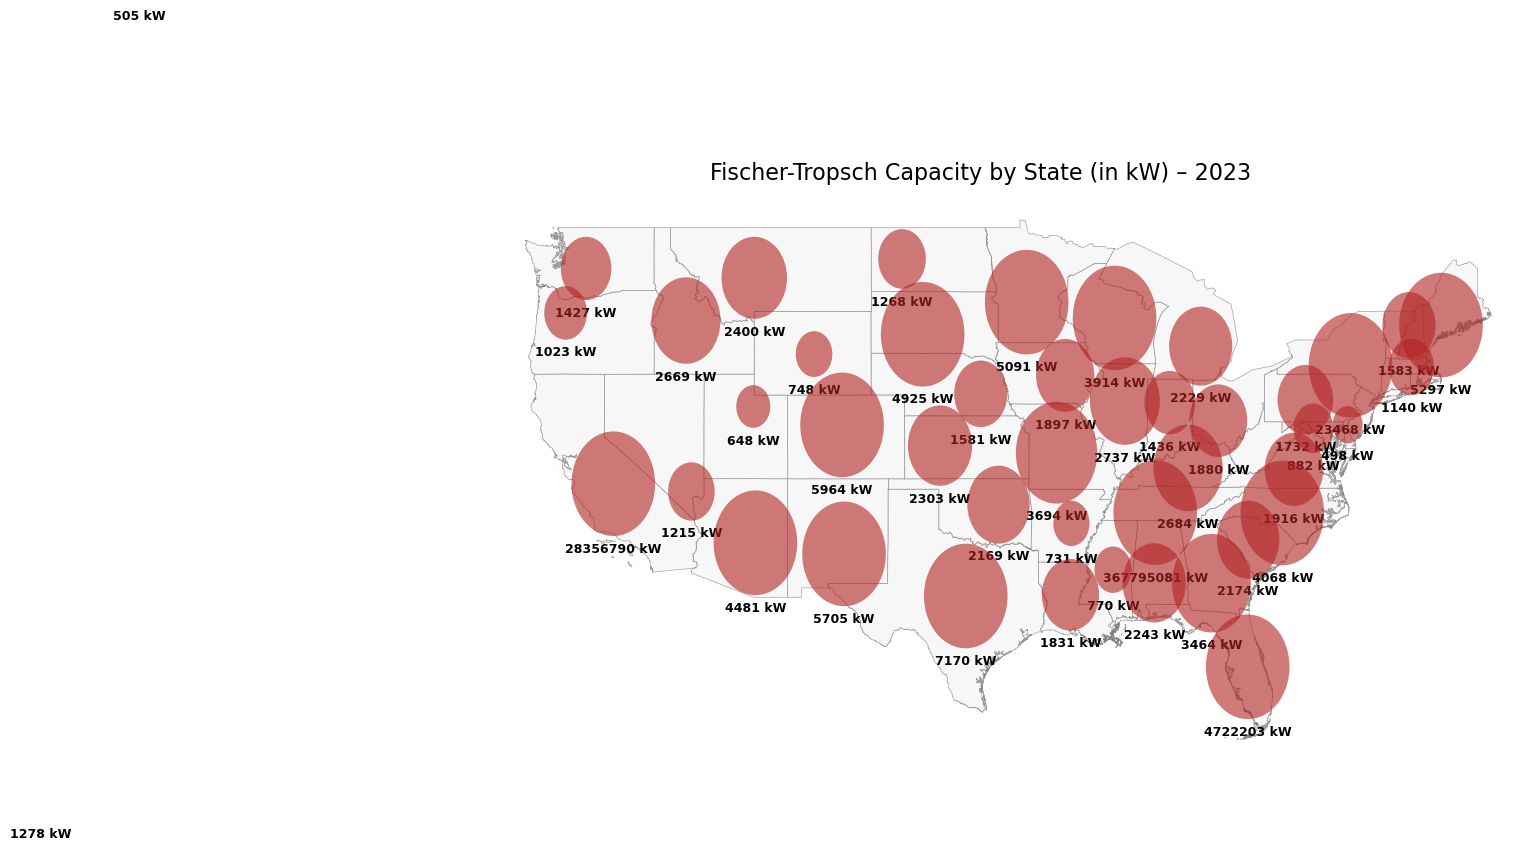

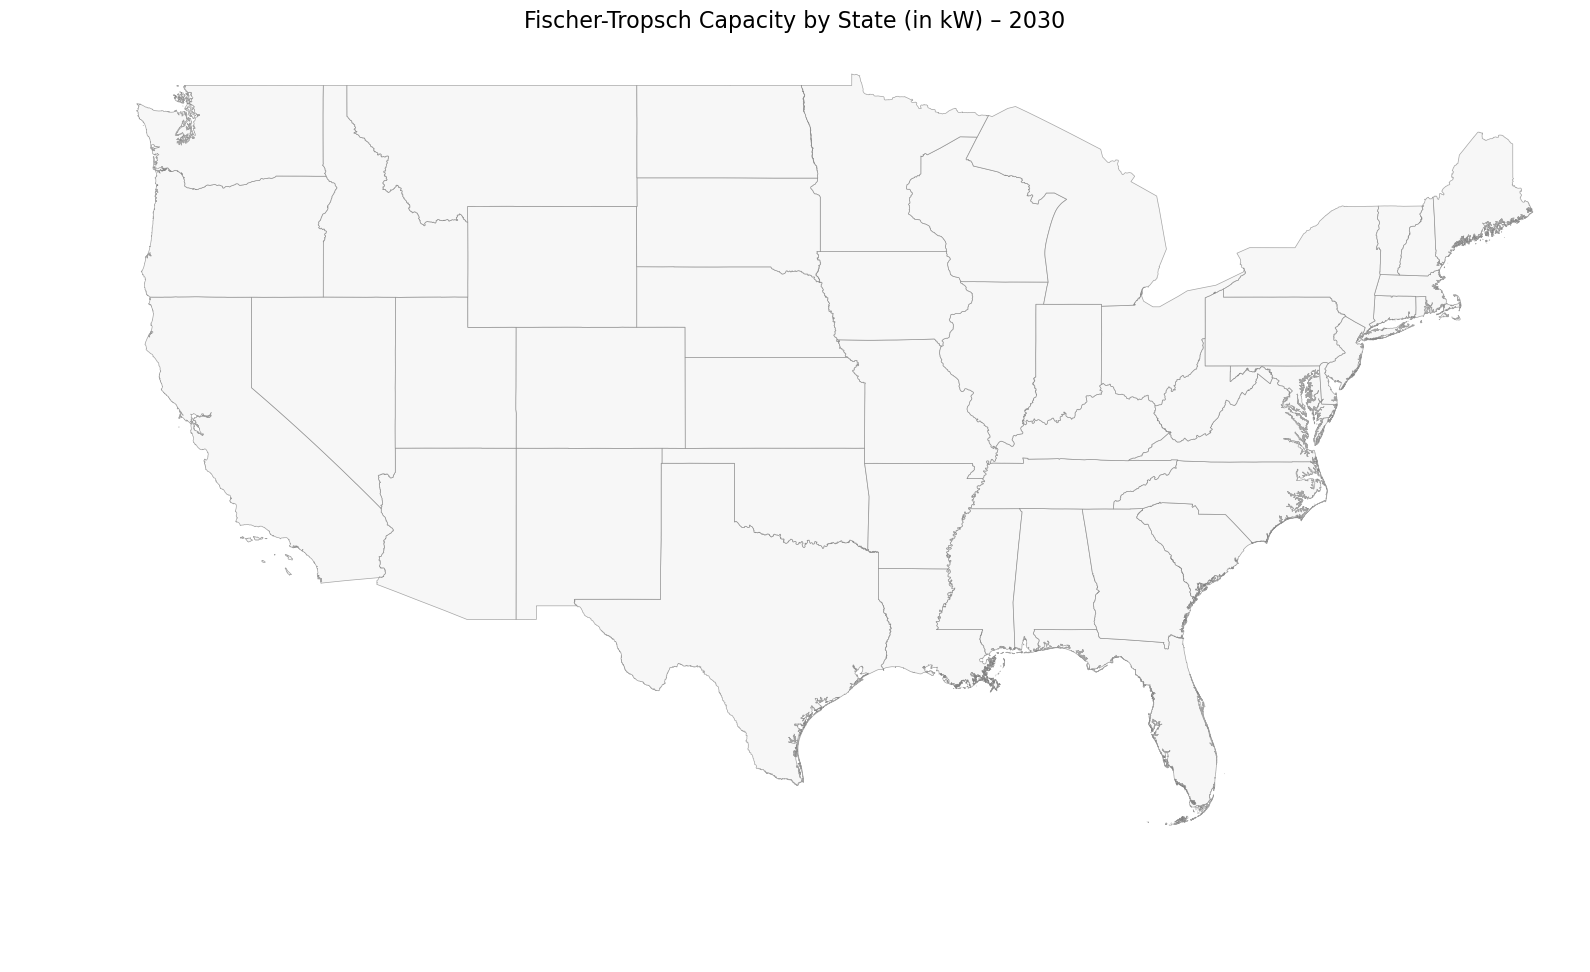

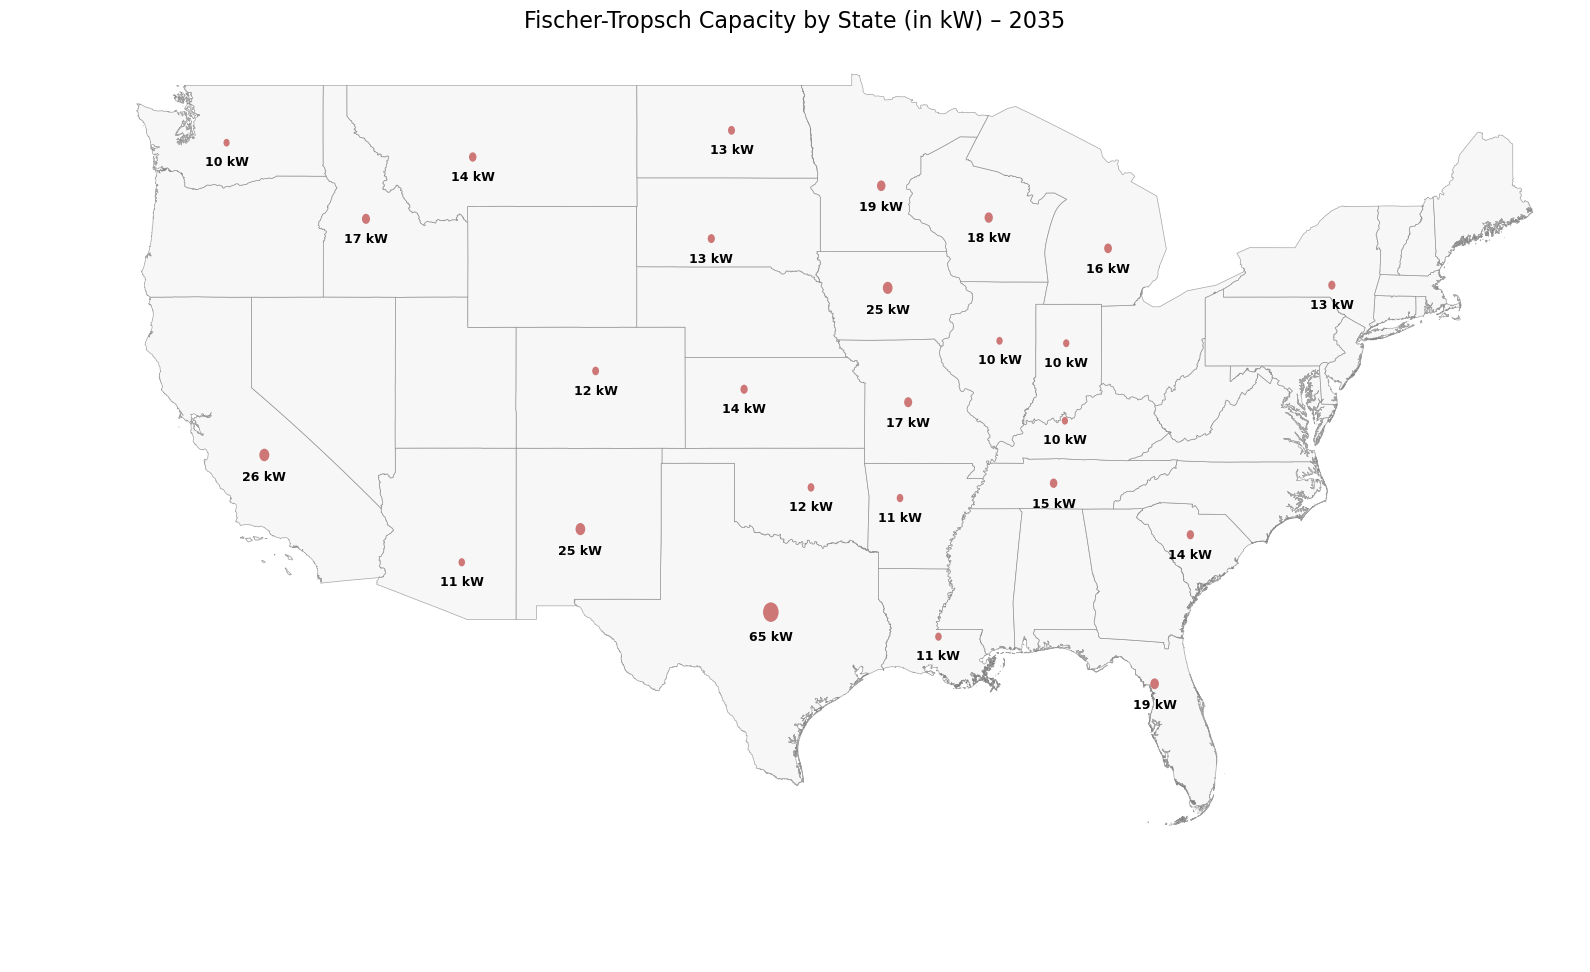

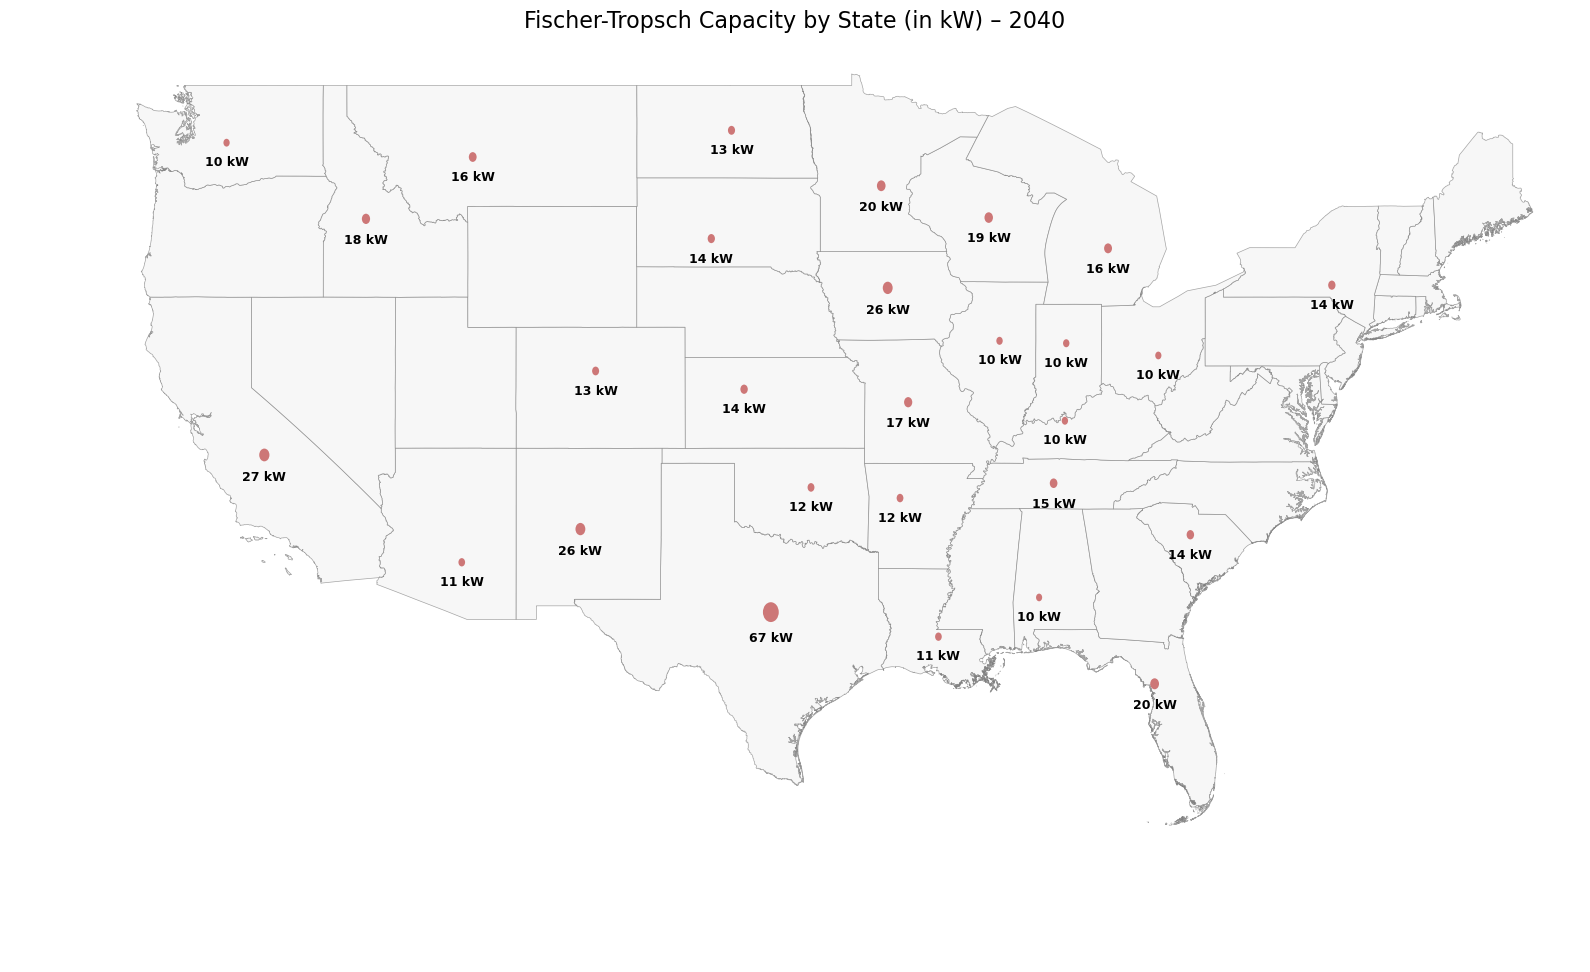

In [28]:
for name, net in networks.items():
    print(f"Plotting FT map for: {name}")
    fig, ax, data = create_ft_capacity_map(
        net.copy(),
        path_shapes=state_shapes_path,
        network_name=name,
        min_capacity_kw=10
    )

Plotting FT map by grid region: Base_2023
Plotting FT map by grid region: scenario_01_2030
Plotting FT map by grid region: scenario_01_2035
Plotting FT map by grid region: scenario_01_2040


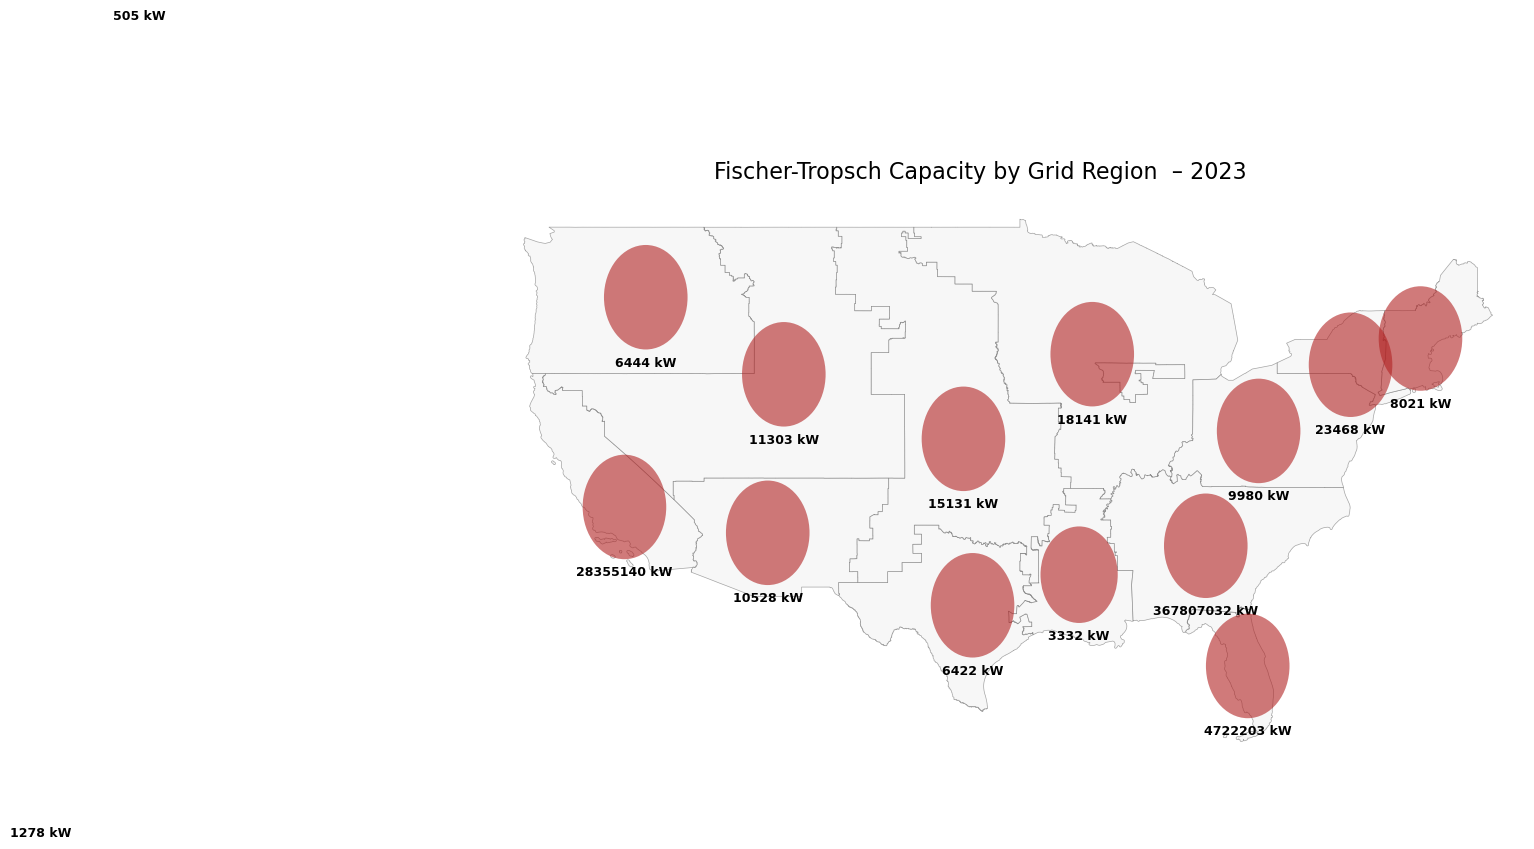

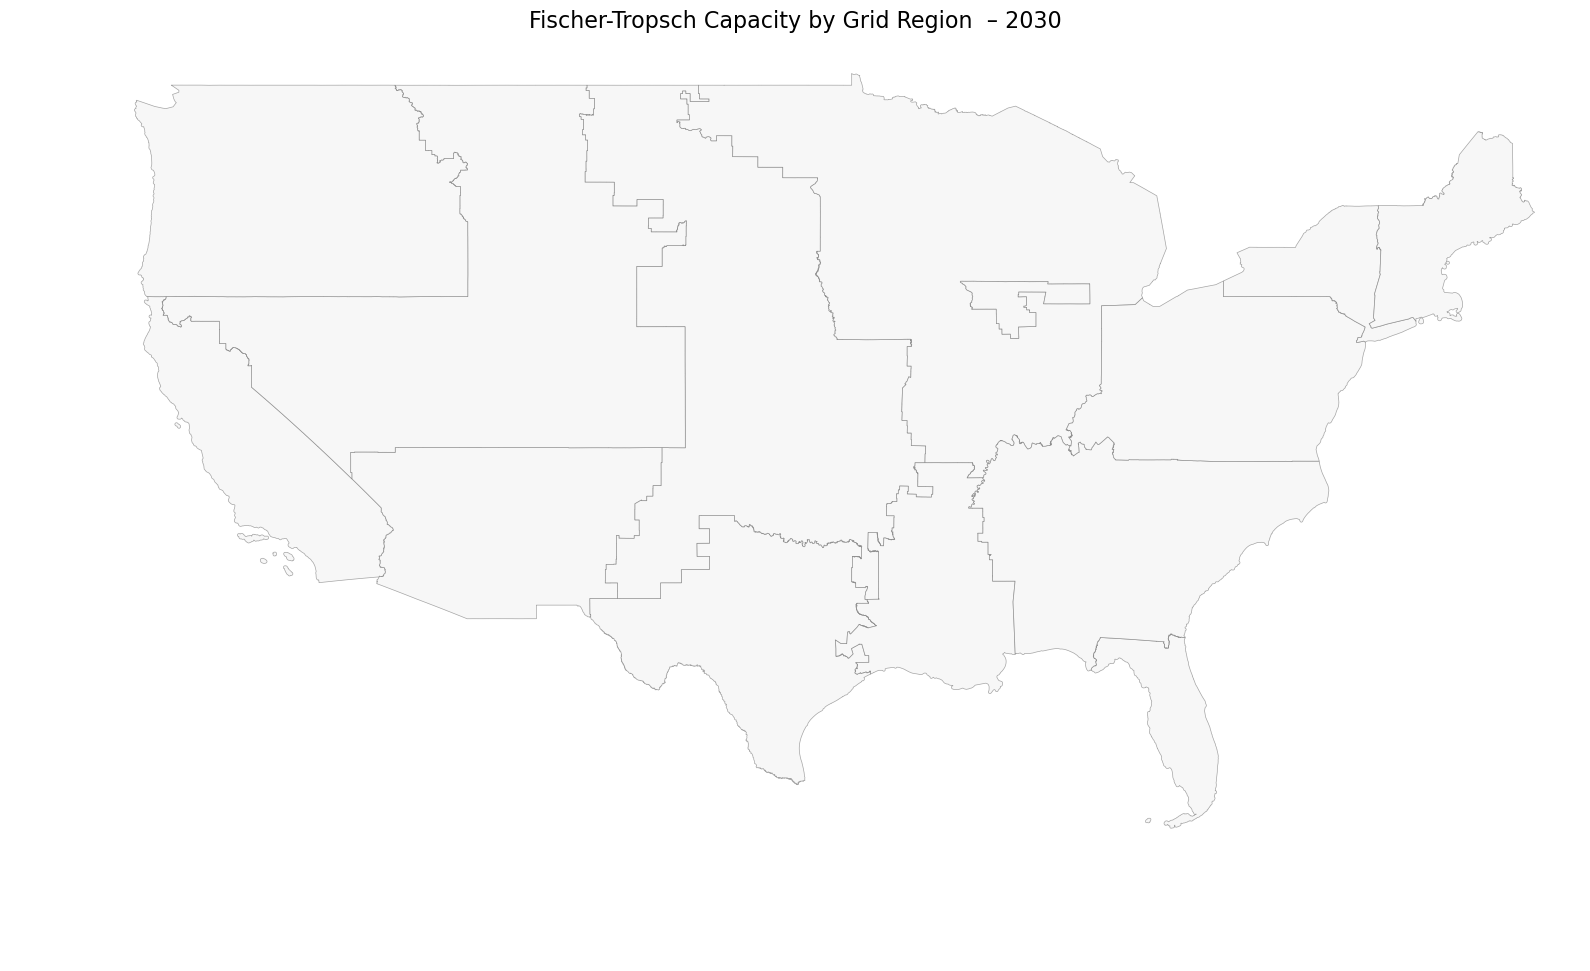

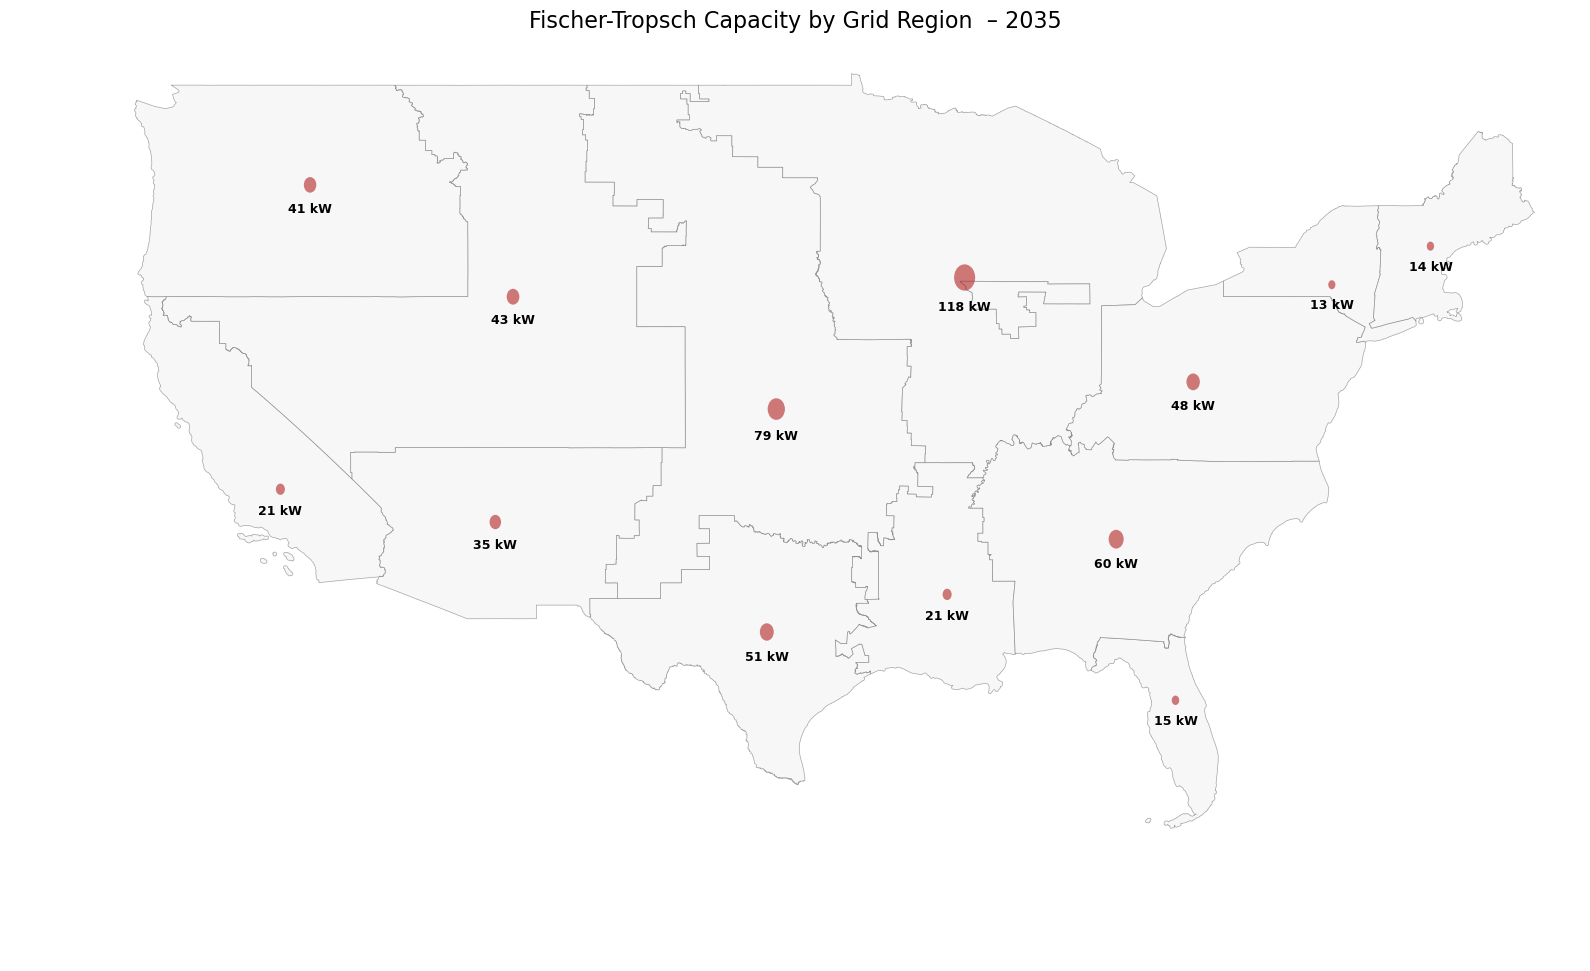

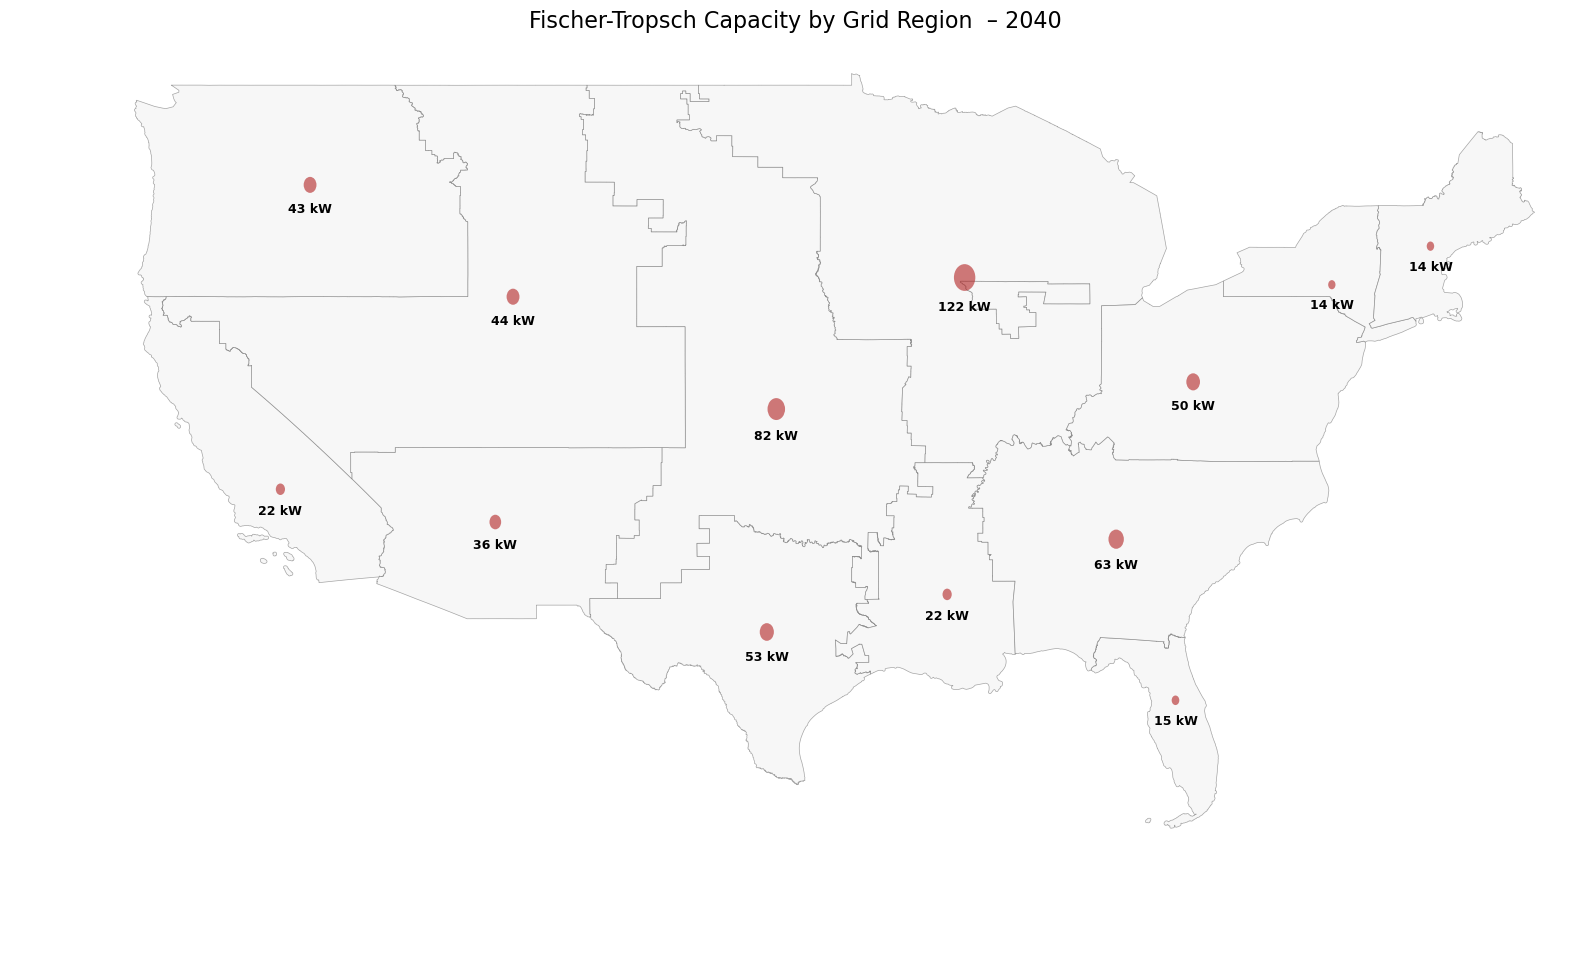

In [29]:
for name, net in networks.items():
    print(f"Plotting FT map by grid region: {name}")
    fig, ax, data = create_ft_capacity_by_grid_region_map(
        net.copy(),
        path_shapes=grid_region_shapes_path,
        network_name=name,
        min_capacity_kw=10
    )

### 4.4. Map: Expanded Capacity per Planning Horizon
*This analysis focuses only on the **newly added** capacity for key technologies (Electricity, H2, FT) within the planning period, rather than the total capacity.*

In [30]:
# Code to calculate the difference between p_nom_opt and p_nom
# and plot the expansion on a map.
pass

---

## 5. Operational Analysis: How Does the System Work?

*This section explores the temporal dispatch of different technologies to meet demand throughout the year.*

### 5.1. Annual Electricity & Hydrogen Dispatch
*A line plot showing the generation from different carriers (for electricity) and production from electrolyzers (for hydrogen) for every hour of the year. This reveals the operational dynamics and intermittency management.*

Processing network: Base_2023
Processing network: scenario_01_2030
Processing network: scenario_01_2035
Processing network: scenario_01_2040


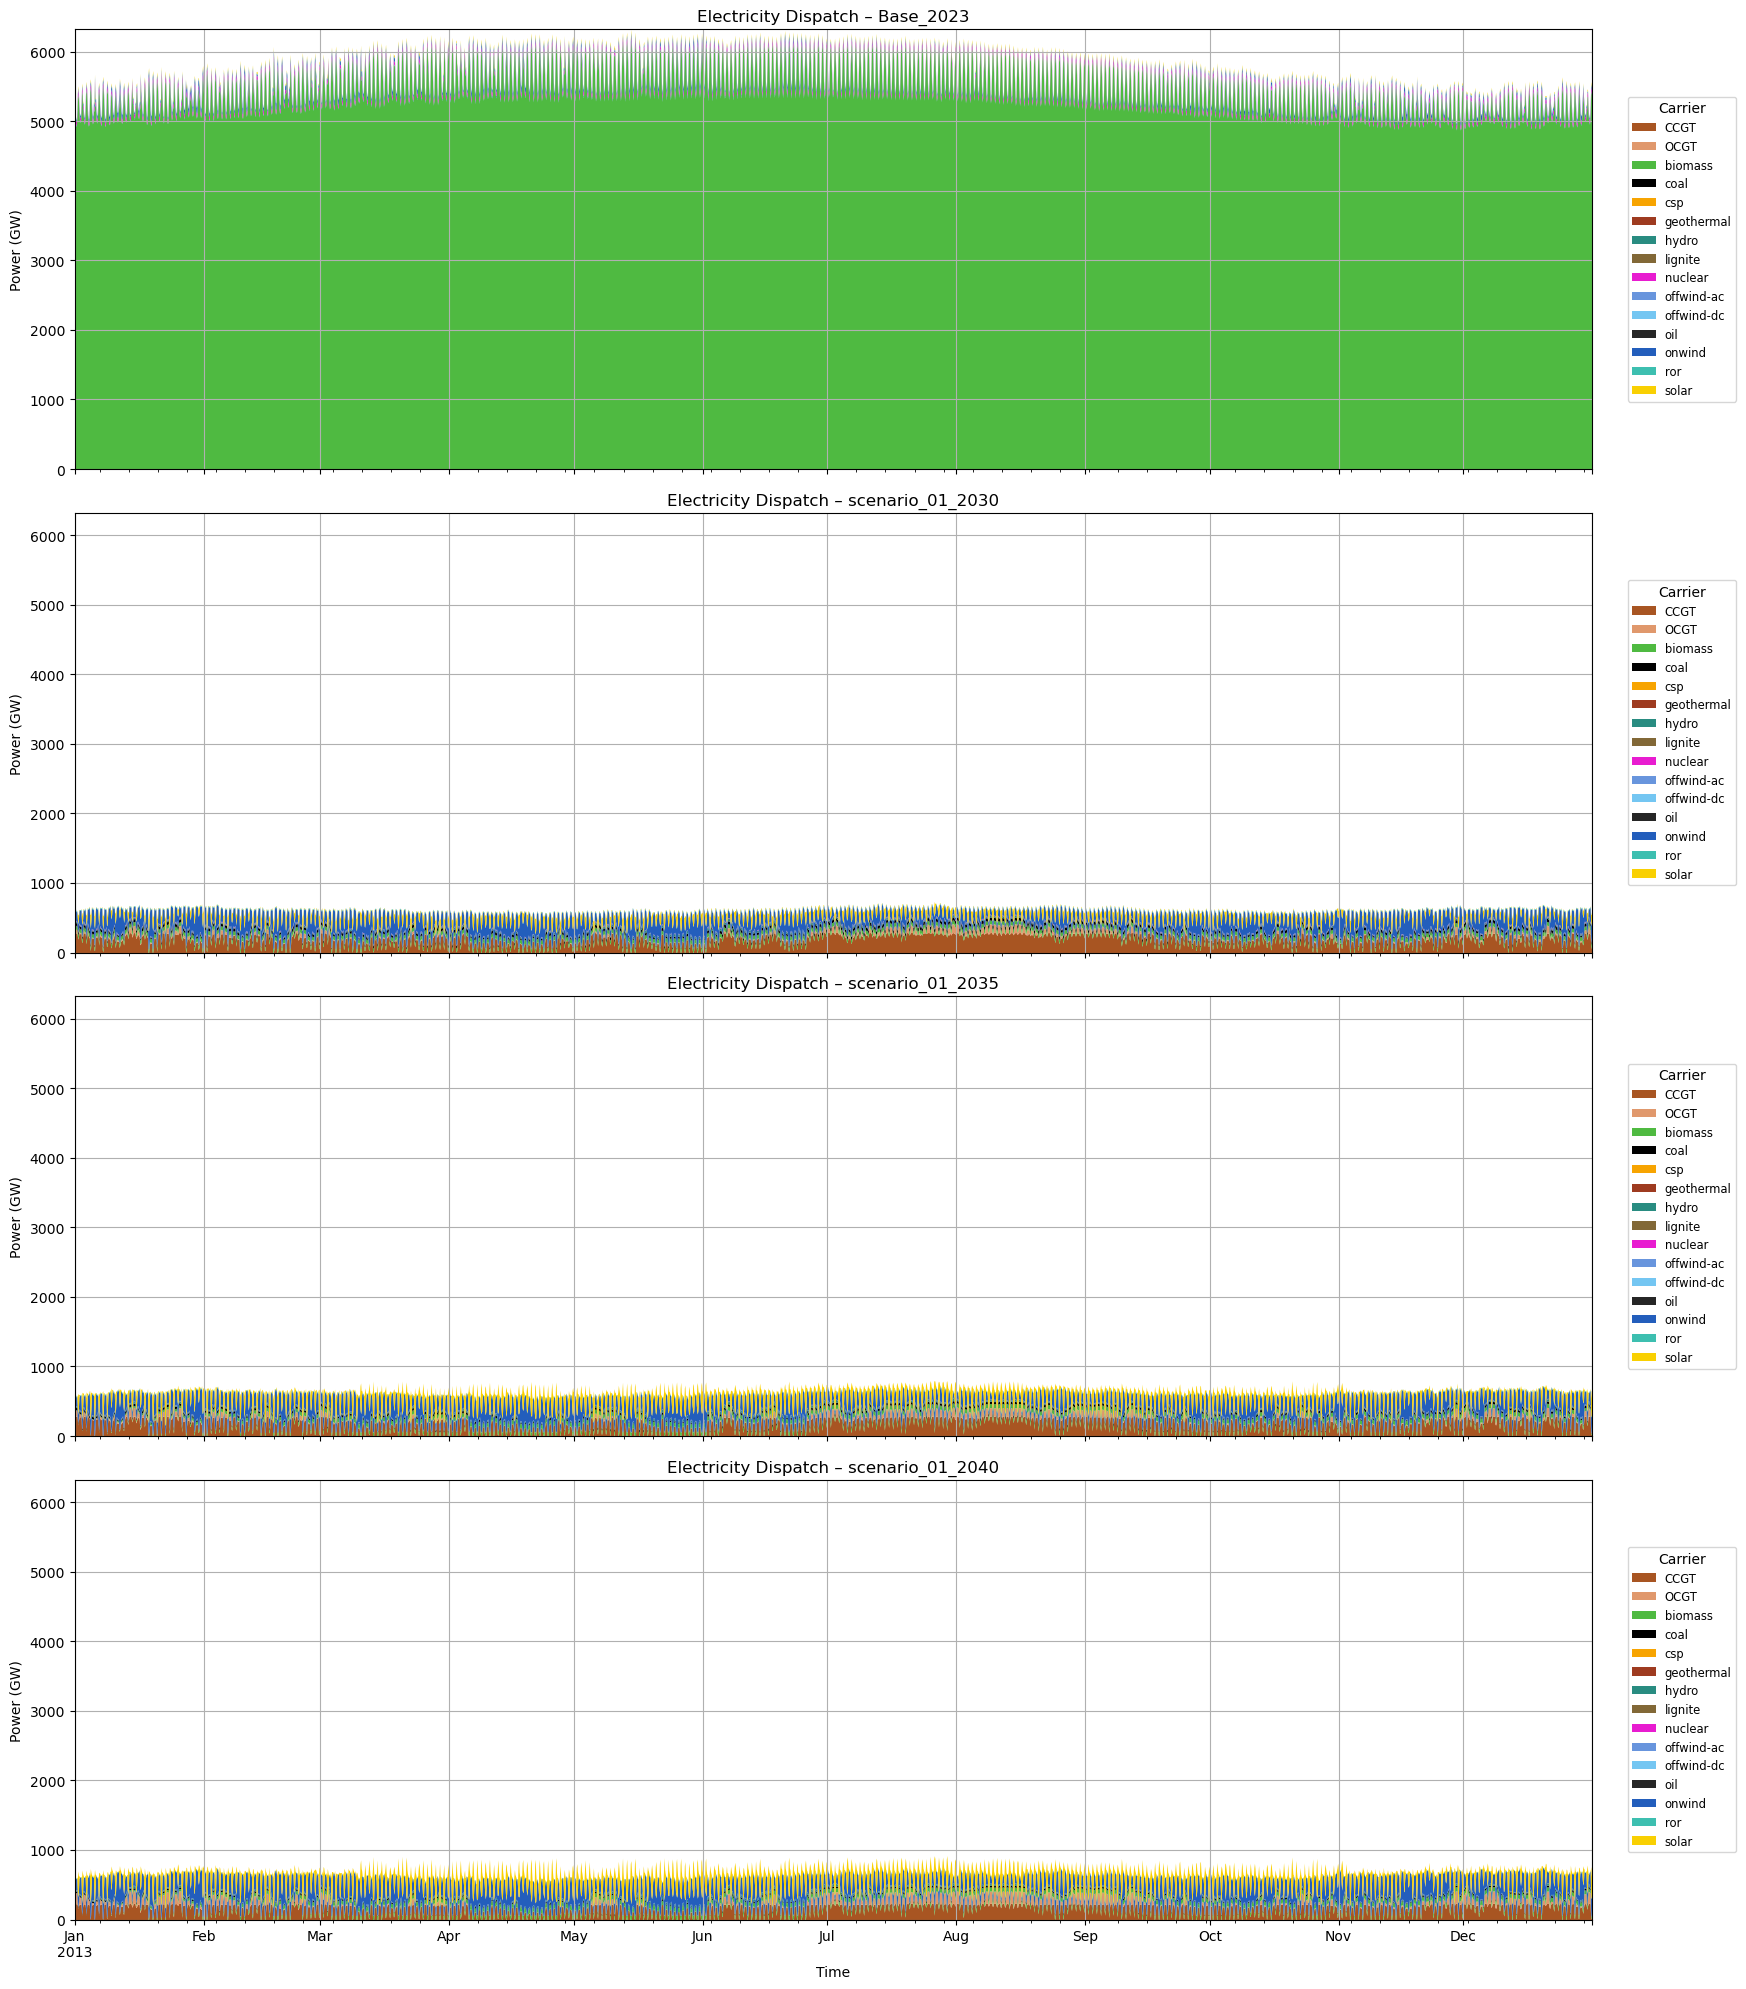

In [31]:
summary_list = []
max_y = 0

# Calcolo massimo valore di y e raccolta summary
for key, n in networks.items():
    print(f"Processing network: {key}")
    total_gwh, supply_gw = calculate_dispatch(n)  # senza date se vuoi tutto
    summary_list.append({"Network": key, "Total Dispatch (GWh)": total_gwh})
    max_y = max(max_y, supply_gw.sum(axis=1).max())

ymax = max_y

fig, axes = plt.subplots(len(networks), 1, figsize=(22, 5 * len(networks)), sharex=True)

if len(networks) == 1:
    axes = [axes]

for ax, (key, n) in zip(axes, networks.items()):
    _, supply_gw = calculate_dispatch(n)
    supply_gw.plot.area(
        ax=ax,
        stacked=True,
        linewidth=0,
        color=[tech_colors.get(c, 'gray') for c in supply_gw.columns],
        legend=False  # disattiva quella automatica
    )
    ax.set_title(f"Electricity Dispatch – {key}")
    ax.set_ylabel("Power (GW)")
    ax.set_ylim(0, ymax)
    ax.grid(True)

    # Legenda a destra, fuori dal plot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        title='Carrier',
        fontsize='small',
        title_fontsize='medium'
    )

axes[-1].set_xlabel("Time")
plt.tight_layout(rect=[0, 0, 0.80, 1])  # lascia spazio a destra
plt.show()

In [32]:
summary_list = []

for key, n in networks.items():
    print(f"Processing load profile for network: {key}")
    
    # Calcola totale dispatch in GWh
    total_dispatch_gwh = calculate_dispatch(n)[0]

    # Calcola load dinamico e statico senza plot
    freq = pd.infer_freq(n.loads_t.p_set.index)
    snapshot_hours = 1 if freq is None else pd.Timedelta(freq).total_seconds() / 3600

    dynamic_load_gw = n.loads_t.p_set.sum(axis=1) / 1e3
    total_dynamic_gwh = (n.loads_t.p_set.sum(axis=1) * snapshot_hours).sum() / 1e3

    static_loads = n.loads[~n.loads.index.isin(n.loads_t.p_set.columns)]
    static_load_gw = static_loads["p_set"].sum() / 1e3
    total_hours = len(n.loads_t.p_set.index) * snapshot_hours
    total_static_gwh = static_load_gw * total_hours

    total_load_gwh = total_dynamic_gwh + total_static_gwh
    diff_percent = 100 * (total_load_gwh - total_dispatch_gwh) / total_load_gwh if total_load_gwh != 0 else 0

    # Converti tutto in TWh e arrotonda a 2 decimali
    summary = {
        "Network": key,
        "Mean Dynamic Load (GW)": round(dynamic_load_gw.mean(), 2),
        "Total Dynamic Load (TWh)": round(total_dynamic_gwh / 1e3, 2),
        "Static Load (GW)": round(static_load_gw, 2),
        "Total Static Load (TWh)": round(total_static_gwh / 1e3, 2),
        "Total Load (TWh)": round(total_load_gwh / 1e3, 2),
        "Total Dispatch (TWh)": round(total_dispatch_gwh / 1e3, 2),
        "Diff Load vs Dispatch (%)": round(diff_percent, 2),
    }

    summary_list.append(summary)

summary_df = pd.DataFrame(summary_list)
summary_df = summary_df.sort_values(by="Total Dispatch (TWh)", ascending=False)
display(summary_df)


Processing load profile for network: Base_2023
Processing load profile for network: scenario_01_2030
Processing load profile for network: scenario_01_2035
Processing load profile for network: scenario_01_2040


Network  Mean Dynamic Load (GW)  Total Dynamic Load (TWh)  \
0         Base_2023                 1342.95                  11764.26   
3  scenario_01_2040                 1282.19                  11232.01   
2  scenario_01_2035                 1294.62                  11340.90   
1  scenario_01_2030                 1321.99                  11580.65   

   Static Load (GW)  Total Static Load (TWh)  Total Load (TWh)  \
0            351.16                  3076.12          14840.38   
3            554.63                  4858.59          16090.60   
2            517.24                  4530.99          15871.89   
1            473.39                  4146.88          15727.53   

   Total Dispatch (TWh)  Diff Load vs Dispatch (%)  
0              48964.73                    -229.94  
3               6023.58                      62.56  
2               5672.58                      64.26  
1               5249.65                      66.62

---

## 6. Economic Analysis: What Are the Unit Costs?

*We break down the system costs to find the levelized cost of key energy vectors in different locations.*

### 6.1. Map: Levelized Cost of Electricity (LCOE)
*A map displaying the LCOE at different buses. This shows the all-in cost of producing electricity at various points in the network.*

In [33]:
shapes = gpd.read_file(grid_region_shapes_path)

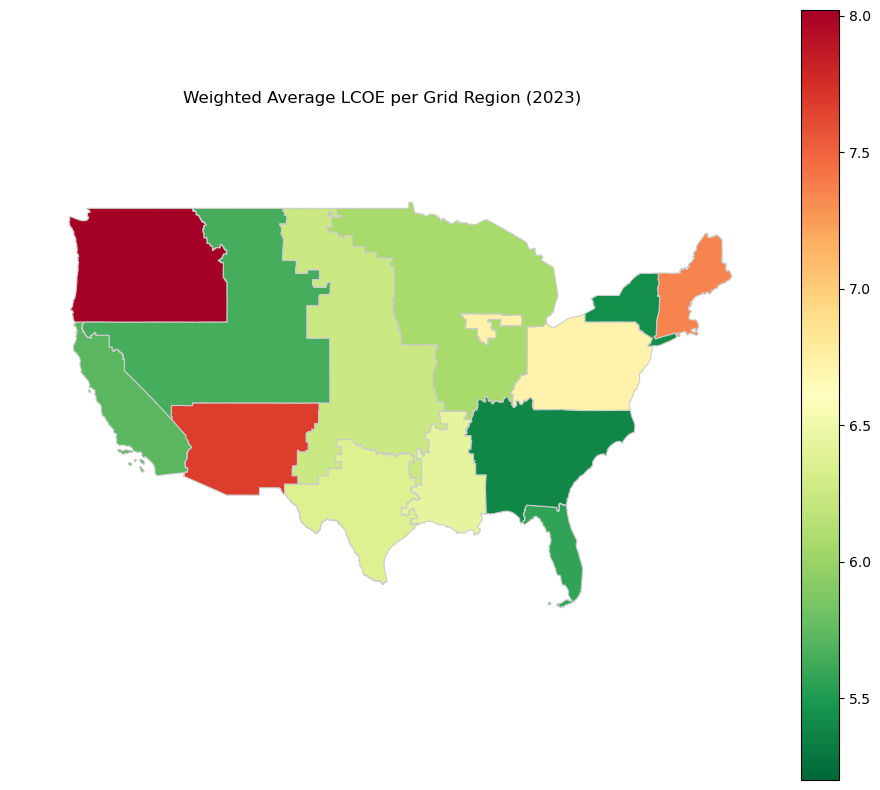

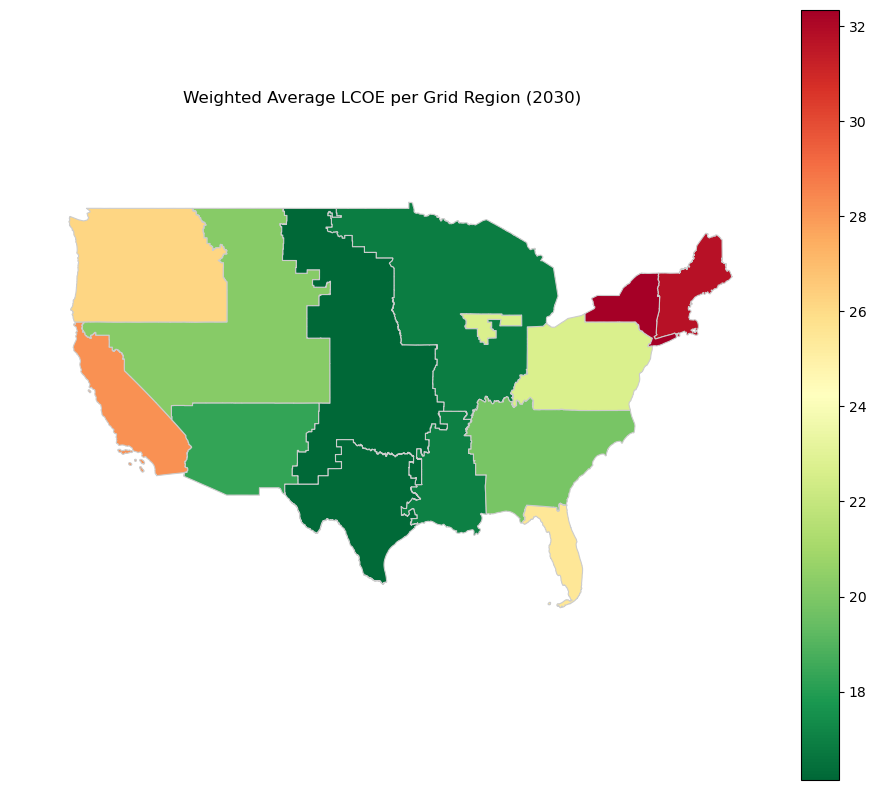

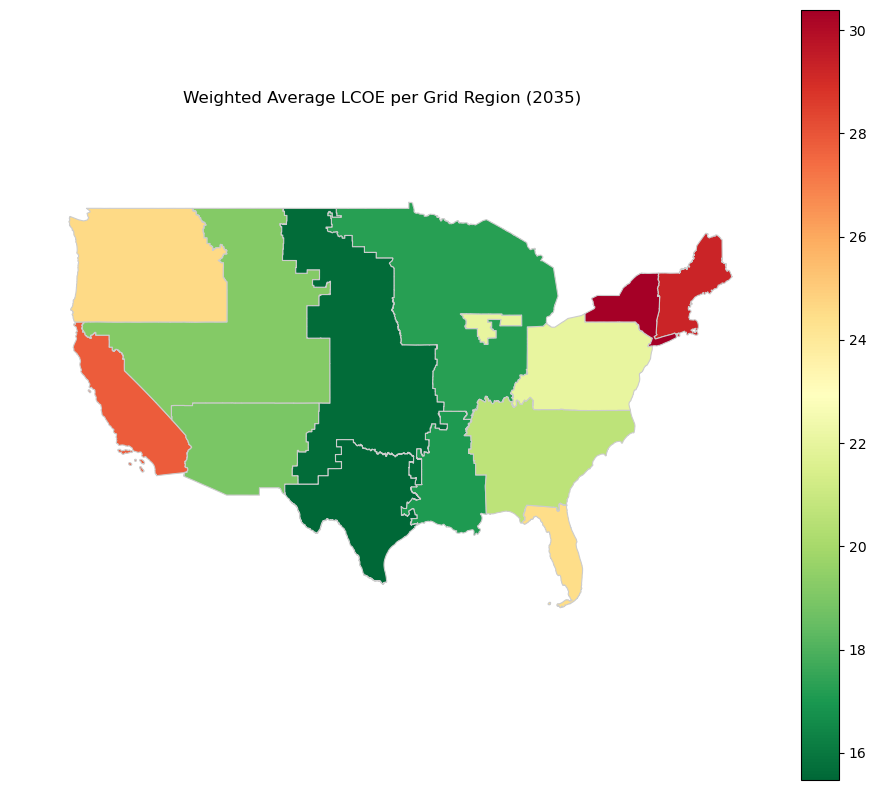

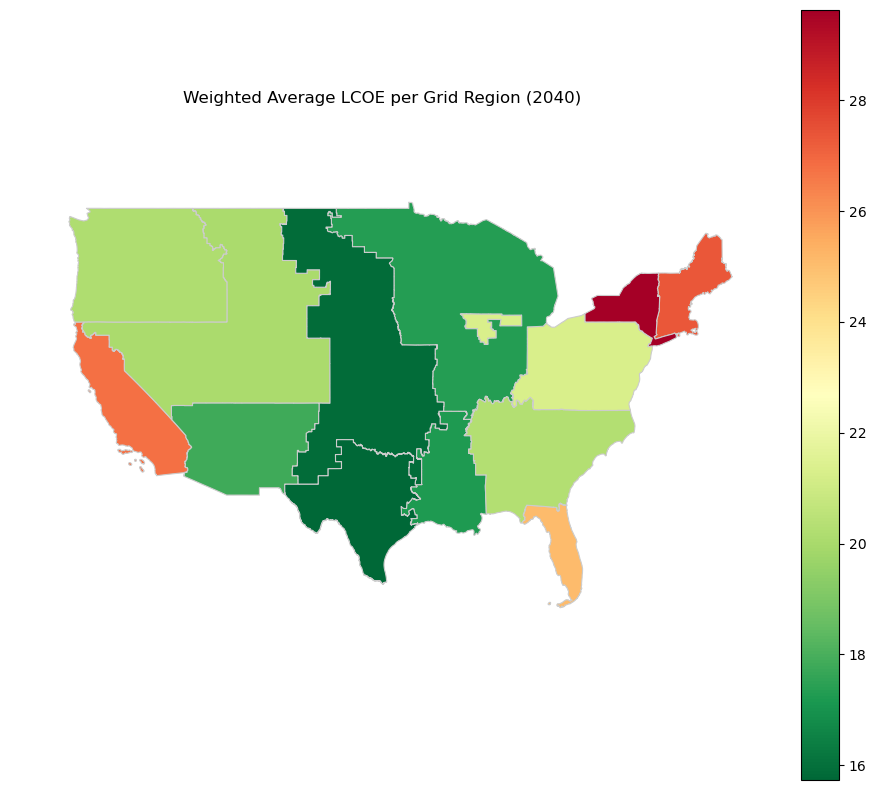

In [34]:
plots_data = {}

for key, net in networks.items():
    year_match = re.search(r'\d{4}', key)
    year_str = year_match.group() if year_match else "Year N/A"
    title = f"Weighted Average LCOE per Grid Region ({year_str})"

    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    lcoe_gdf, table, lcoe_by_bus, lcoe_data, vmin, vmax = calculate_lcoe_summary_and_map(net, shapes)
    plots_data[key] = table

    plot_lcoe_map_by_grid_region(lcoe_by_bus, lcoe_data, shapes, title=title, key=key, ax=ax)
    plt.show()


In [35]:
def uppercase_only_lcoe_word(df):
    new_cols = {
        col: re.sub(r'\blcoe\b', 'LCOE', col, flags=re.IGNORECASE)
        for col in df.columns
    }
    return df.rename(columns=new_cols)

for net_name, table in plots_data.items():
    print(f"\nTable for network: {net_name}")
    display(uppercase_only_lcoe_word(table))


Table for network: Base_2023


grid_region  biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  \
0         Alaska                    5.01                 5.31   
1     California                    5.01                  NaN   
2          Delta                    5.01                 5.31   
3        Florida                    5.01                 5.31   
4         Hawaii                    5.01                  NaN   
5   Mid-Atlantic                    5.01                 5.31   
6        Midwest                    5.01                 5.31   
7       Mountain                    5.01                 5.31   
8    New England                    5.01                  NaN   
9       New York                    5.01                  NaN   
10     Northwest                    5.01                 5.31   
11        Plains                    5.01                 5.31   
12     Southeast                    5.01                 5.31   
13     Southwest                    5.01                 5.31   
14         Texas                    5.01                 5.31   

    gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  hydro LCOE [USD/MWh]  \
0                 8.83                        NaN                  0.01   
1                 8.83                20081880.37                  0.01   
2                 8.83                        NaN                  0.01   
3                 8.83                        NaN                   NaN   
4                 8.83                 1617993.92                   NaN   
5                 8.83                        NaN                  0.01   
6                 8.83                        NaN                  0.01   
7                 8.83                 3277338.17                  0.01   
8                 8.83                        NaN                  0.01   
9                 8.83                        NaN                  0.01   
10                8.83                13010416.23                  0.01   
11                8.83                 5729179.92                  0.01   
12                8.83                        NaN                  0.01   
13                8.83                 1929502.68                  0.01   
14                8.83                        NaN                  0.01   

    nuclear LCOE [USD/MWh]  oil LCOE [USD/MWh]  onwind LCOE [USD/MWh]  \
0                      NaN                 NaN                  40.95   
1                    79.44               29.96                 114.21   
2                    79.44                 NaN                    NaN   
3                    79.44               29.96                    NaN   
4                      NaN                 NaN                  24.16   
5                    79.44               29.96                  40.74   
6                    79.44               29.96                  22.31   
7                      NaN               29.96                  28.65   
8                    79.44               29.96                  48.01   
9                    79.44               29.96                  49.59   
10                   79.44                 NaN                  95.22   
11                   79.44               29.96                  18.95   
12                   79.44               29.96                 116.24   
13                   79.44               29.96                  51.05   
14                   79.44                 NaN                  18.42   

    ror LCOE [USD/MWh]  ...  coal dispatch [TWh]  gas dispatch [TWh]  \
0                  NaN  ...                 0.00                 0.0   
1                  NaN  ...                 0.00                 0.0   
2                  NaN  ...                 0.00                 0.0   
3                  NaN  ...                 0.00                 0.0   
4                  NaN  ...                 0.00                 0.0   
5                 44.7  ...                37.26                 0.0   
6                  NaN  ...                15.44                 0.0   
7                 


Table for network: scenario_01_2030


grid_region  biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  \
0         Alaska                   64.28                  NaN   
1     California                   64.28                  NaN   
2          Delta                   64.29                  6.9   
3        Florida                   64.29                  6.9   
4         Hawaii                   64.28                  NaN   
5   Mid-Atlantic                   64.29                  6.9   
6        Midwest                   64.29                  6.9   
7       Mountain                   64.29                  6.9   
8    New England                   64.29                  NaN   
9       New York                   64.28                  NaN   
10     Northwest                   64.29                  6.9   
11        Plains                   64.29                  6.9   
12     Southeast                   64.28                  6.9   
13     Southwest                   64.29                  6.9   
14         Texas                   64.29                  6.9   

    csp LCOE [USD/MWh]  gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  \
0                  NaN               16.21                        NaN   
1                  NaN               16.21                      59.67   
2                  NaN               16.21                        NaN   
3                  NaN               16.21                        NaN   
4                  NaN               16.21                      68.05   
5                  NaN               16.21                        NaN   
6                  NaN               16.21                        NaN   
7                  NaN               16.21                      60.66   
8               439.29               16.21                        NaN   
9                  NaN               16.21                        NaN   
10                 NaN               16.21                      60.34   
11                 NaN               16.21                      67.70   
12                 NaN               16.21                        NaN   
13                 NaN               16.21                      62.63   
14                 NaN               16.21                        NaN   

    hydro LCOE [USD/MWh]  nuclear LCOE [USD/MWh]  offwind-dc LCOE [USD/MWh]  \
0                   0.01                     NaN                     264.49   
1                   0.01                  149.74                     180.34   
2                   0.01                  146.98                     281.82   
3                    NaN                  128.70                     278.33   
4                    NaN                     NaN                     162.09   
5                   0.01                   99.05                     155.88   
6                   0.01                  133.40                        NaN   
7                   0.01                     NaN                     134.73   
8                   0.01                   99.17                     140.27   
9                   0.01                  135.54                     127.31   
10                  0.01                  143.43                     169.58   
11                  0.01                  135.55                     198.26   
12                  0.01                   98.08                     241.57   
13                  0.01                  135.30                        NaN   
14                  0.01                  122.43                     260.33   

    oil LCOE [USD/MWh]  ...  gas dispatch [TWh]  geothermal dispatch [TWh]  \
0                  NaN  ...               11.91                       0.00   
1                50.99  ...              639.89                       5.75   
2                  NaN  ...              470.39                       0.00   
3                50.99  ...              498.32                       0.00   
4                  NaN  ...               24.50                       0.11   
5                50.99  ...             1604.77               


Table for network: scenario_01_2035


grid_region  biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  \
0         Alaska                   64.29                  NaN   
1     California                   64.29                  NaN   
2          Delta                   64.29                  6.9   
3        Florida                   64.29                  6.9   
4         Hawaii                   64.28                  NaN   
5   Mid-Atlantic                   64.29                  6.9   
6        Midwest                   64.29                  6.9   
7       Mountain                   64.29                  6.9   
8    New England                   64.29                  NaN   
9       New York                   64.29                  NaN   
10     Northwest                   64.29                  6.9   
11        Plains                   64.29                  6.9   
12     Southeast                   64.29                  6.9   
13     Southwest                   64.28                  6.9   
14         Texas                   64.29                  6.9   

    csp LCOE [USD/MWh]  gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  \
0                  NaN               16.21                        NaN   
1                  NaN               16.21                      64.58   
2                  NaN               16.21                        NaN   
3                  NaN               16.21                        NaN   
4                  NaN               16.21                      70.54   
5                  NaN               16.21                        NaN   
6                  NaN               16.21                        NaN   
7                  NaN               16.21                      65.21   
8                428.8               16.21                        NaN   
9                  NaN               16.21                        NaN   
10                 NaN               16.21                      65.84   
11                 NaN               16.21                      71.07   
12                 NaN               16.21                        NaN   
13                 NaN               16.21                      66.49   
14                 NaN               16.21                        NaN   

    hydro LCOE [USD/MWh]  nuclear LCOE [USD/MWh]  offwind-dc LCOE [USD/MWh]  \
0                   0.01                     NaN                     196.76   
1                   0.01                  148.78                     165.32   
2                   0.01                  158.33                     238.95   
3                    NaN                  156.87                     248.51   
4                    NaN                     NaN                     150.89   
5                   0.01                  155.22                     139.88   
6                   0.01                  159.35                        NaN   
7                   0.01                     NaN                     129.49   
8                   0.01                  152.83                     129.37   
9                   0.01                  154.89                     131.00   
10                  0.01                  155.56                     168.03   
11                  0.01                  164.14                     180.66   
12                  0.01                  104.19                     213.83   
13                  0.01                  161.19                        NaN   
14                  0.01                  163.74                     225.31   

    oil LCOE [USD/MWh]  ...  gas dispatch [TWh]  geothermal dispatch [TWh]  \
0                  NaN  ...               12.81                       0.00   
1                50.99  ...              460.69                       4.62   
2                  NaN  ...              494.21                       0.00   
3                50.99  ...              486.34                       0.00   
4                  NaN  ...               28.01                       0.11   
5                50.99  ...             1652.60               


Table for network: scenario_01_2040


grid_region  biomass LCOE [USD/MWh]  coal LCOE [USD/MWh]  \
0         Alaska                   64.29                  NaN   
1     California                   64.29                  NaN   
2          Delta                   64.29                  6.9   
3        Florida                   64.29                  NaN   
4         Hawaii                   64.28                  NaN   
5   Mid-Atlantic                   64.29                  6.9   
6        Midwest                   64.29                  6.9   
7       Mountain                   64.29                  6.9   
8    New England                   64.29                  NaN   
9       New York                   64.29                  NaN   
10     Northwest                   64.29                  6.9   
11        Plains                   64.29                  6.9   
12     Southeast                   64.29                  6.9   
13     Southwest                   64.28                  6.9   
14         Texas                   64.29                  6.9   

    csp LCOE [USD/MWh]  gas LCOE [USD/MWh]  geothermal LCOE [USD/MWh]  \
0                  NaN               16.21                        NaN   
1                  NaN               16.21                      66.02   
2                  NaN               16.21                        NaN   
3                  NaN               16.21                        NaN   
4                  NaN               16.21                      69.77   
5                  NaN               16.21                        NaN   
6                  NaN               16.21                        NaN   
7                  NaN               16.21                      67.38   
8               661.84               16.21                        NaN   
9                  NaN               16.21                        NaN   
10                 NaN               16.21                      65.92   
11                 NaN               16.21                      75.67   
12                 NaN               16.21                        NaN   
13                 NaN               16.21                      70.24   
14                 NaN               16.21                        NaN   

    hydro LCOE [USD/MWh]  nuclear LCOE [USD/MWh]  offwind-dc LCOE [USD/MWh]  \
0                   0.01                     NaN                     185.22   
1                   0.01                  131.11                     133.39   
2                   0.01                  124.04                     171.78   
3                    NaN                  120.33                     175.49   
4                    NaN                     NaN                     123.37   
5                   0.01                  122.39                     104.18   
6                   0.01                  133.15                        NaN   
7                   0.01                     NaN                     105.30   
8                   0.01                  116.29                      97.28   
9                   0.01                  122.56                      98.92   
10                  0.01                  129.75                     126.38   
11                  0.01                  149.54                     150.38   
12                  0.01                  106.68                     153.23   
13                  0.01                  133.72                        NaN   
14                  0.01                  142.91                     188.40   

    oil LCOE [USD/MWh]  ...  gas dispatch [TWh]  geothermal dispatch [TWh]  \
0                  NaN  ...               13.70                       0.00   
1                50.99  ...              437.21                       2.73   
2                  NaN  ...              420.05                       0.00   
3                50.99  ...              395.77                       0.00   
4                  NaN  ...               28.73                       0.11   
5                50.99  ...             2024.63               

### 6.2. Map: Levelized Cost of Hydrogen (LCOH)
*A map displaying the LCOH at buses where hydrogen is produced. This is a critical metric for the hydrogen economy.*

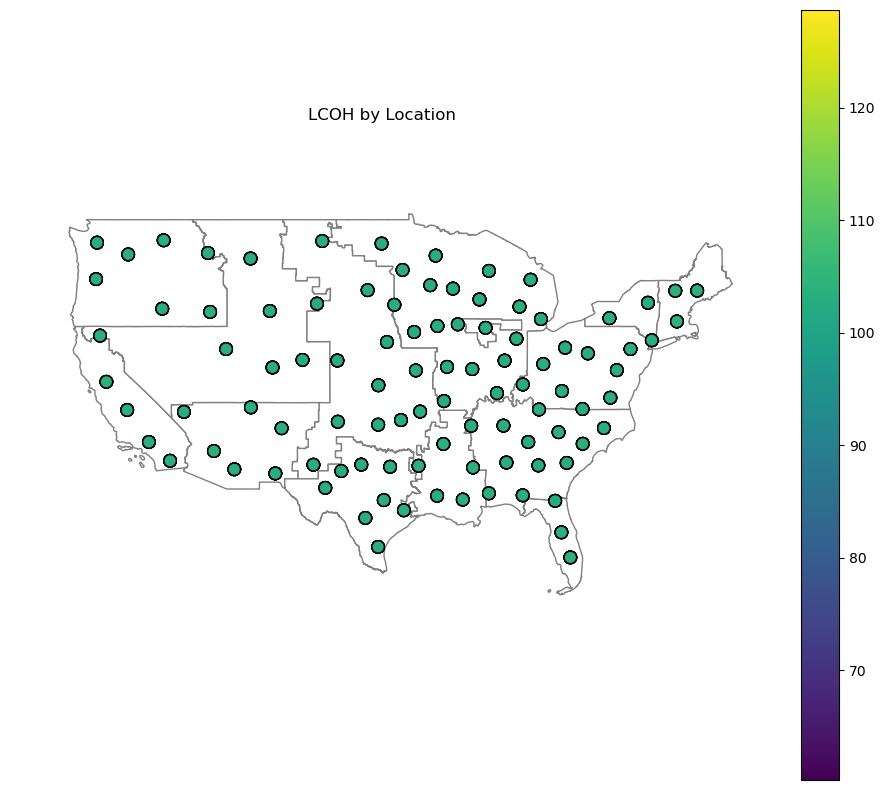

In [36]:
h2_carriers = ["Alkaline electrolyzer large", "Alkaline electrolyzer medium",
            "Alkaline electrolyzer small", "PEM electrolyzer", "SOEC"]

hydrogen_links = n.links.query("carrier in @h2_carriers")
hydrogen_dispatch = n.links_t.p0[hydrogen_links.index]  # p0 is power input to electrolyzers

# Total H2 energy output: p1 is H2 output
h2_output = -n.links_t.p1[hydrogen_links.index].sum(axis=0)

lcoh = (hydrogen_links.capital_cost * hydrogen_links.p_nom_opt + hydrogen_links.marginal_cost * h2_output) / h2_output

hydrogen_links['lcoh'] = lcoh
lcoh_data = hydrogen_links[['bus0', 'lcoh', 'carrier']]
lcoh_data = lcoh_data.merge(n.buses[['x', 'y']], left_on='bus0', right_index=True)
lcoh_data['region'] = lcoh_data.bus0.map(n.buses.grid_region)

# Create GeoDataFrame from bus points
geometry = [Point(xy) for xy in zip(lcoh_data['x'], lcoh_data['y'])]
lcoh_gdf = gpd.GeoDataFrame(lcoh_data, geometry=geometry, crs=shapes.crs)
lcoh_gdf = lcoh_gdf.to_crs(shapes.crs)

fig, ax = plt.subplots(figsize=(12, 10))
shapes.plot(ax=ax, color='white', edgecolor='gray')  # Plot the regions

# Scatter LCOE points
lcoh_gdf.plot(
    ax=ax,
    column='lcoh',  # This is the value you're mapping
    cmap='viridis',
    legend=True,
    markersize=80,
    edgecolor='black'
)
plt.xlim([-130, -65])
plt.ylim([20, 55])
plt.title("LCOH by Location")
plt.axis('off')
plt.show()

In [37]:
lcoh_data.groupby(['region', 'carrier'])['lcoh'].sum().unstack()

carrier       Alkaline electrolyzer large  PEM electrolyzer         SOEC
region                                                                  
Alaska                         218.533136        335.477222   281.924925
California                     859.737880       1320.729260  1123.228263
Delta                          874.226409       1340.739984  1126.854166
Florida                        662.666639       1015.757694   848.637566
Hawaii                         217.211472        334.811030   281.768595
Mid-Atlantic                  2202.201741       3377.250152  2821.925394
Midwest                       4251.339799       6527.935451  5588.031768
Mountain                      1456.563340       2242.817427  1942.656103
New England                    665.629331       1020.769235   850.018863
New York                       663.282397       1016.584031   847.787910
Northwest                     1502.923598       2309.446492  1963.469382
Plains                        2494.729430       3835.023735  3329.552718
Southeast                     2656.816712       4077.529286  3393.085201
Southwest                     1274.192111       1959.424194  1677.655378
Texas                         1684.259729       2589.134225  2229.357689

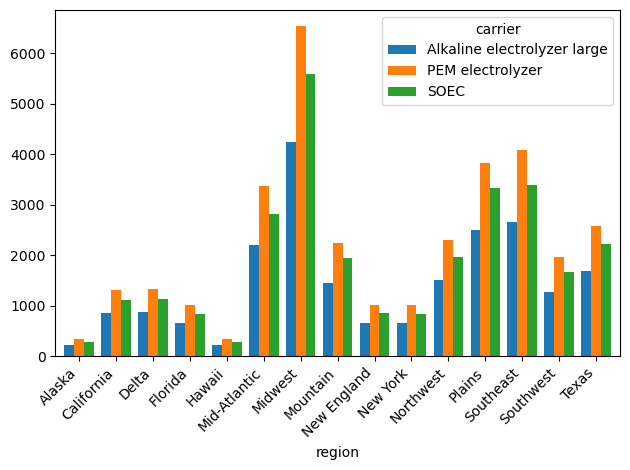

In [38]:
lcoh_data.groupby(['region', 'carrier'])['lcoh'].sum().unstack().plot(
    kind='bar',
    width=0.8
)
ax.set_ylabel('LCOH')
ax.set_xlabel('Region')
ax.set_title('Levelized Cost of Hydrogen (LCOH) by Region and Electrolyzer Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---

## 7. Sector-Specific Analysis: E-Kerosene Deep Dive

*A dedicated section to analyze the production chain, costs, and outputs related to synthetic aviation fuel.*

### 7.1. E-Kerosene Production and Costs
*Analysis of the Fischer-Tropsch process, including inputs (H2, CO2), outputs (e-kerosene), and the resulting levelized cost of the fuel.*

In [39]:
# Code to analyze the FT links, their inputs/outputs,
# and calculate the Levelized Cost of Kerosene (LCOK).
pass

---